In [88]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import joblib
import os
import math


# ***** 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model

## Fase 01

In [89]:
df = pd.read_csv('./data/dataset_balanceado_500p_10r.csv')

In [91]:
df["is_active"] = True

# Transformar datos a tipo fecha
df.created_at = pd.to_datetime(df.created_at)
df.last_order_date = pd.to_datetime(df.last_order_date)
df.last_updated_at = pd.to_datetime(df.last_updated_at)
df.last_stock_count_date = pd.to_datetime(df.last_stock_count_date)
df.expiration_date = pd.to_datetime(df.expiration_date)

In [92]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Iterar sobre cada columna para calcular outliers
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    if not outliers.empty:
        print(f"\nColumna: '{col}'")
        print(f"Límites (IQR): ({lower_bound:.2f}, {upper_bound:.2f})")
        print(f"Total de outliers detectados: {len(outliers)}")
    else:
        print(f"\nColumna: '{col}' -> Sin outliers (según IQR).")


threshold = 3 

for col_2 in numeric_cols:
    z_scores = np.abs(zscore(df[col_2]))

    outliers_2 = df[z_scores > threshold]

    if not outliers.empty:
        print(f"\nColumna: '{col_2}'")
        print(f"Umbral (Z-score): {threshold}")
        print(f"Total de outliers detectados: {len(outliers_2)}")
        # print(outliers[[col_2, 'product_name']].sort_values(by=col_2, ascending=False).head())
    else:
        print(f"\nColumna: '{col_2}' -> Sin outliers (Z-score < {threshold}).")


Columna: 'quantity_on_hand' -> Sin outliers (según IQR).

Columna: 'quantity_reserved' -> Sin outliers (según IQR).

Columna: 'quantity_available' -> Sin outliers (según IQR).

Columna: 'minimum_stock_level' -> Sin outliers (según IQR).

Columna: 'reorder_point' -> Sin outliers (según IQR).

Columna: 'optimal_stock_level' -> Sin outliers (según IQR).

Columna: 'reorder_quantity' -> Sin outliers (según IQR).

Columna: 'average_daily_usage' -> Sin outliers (según IQR).

Columna: 'unit_cost' -> Sin outliers (según IQR).

Columna: 'total_value'
Límites (IQR): (-1011987.06, 2124669.26)
Total de outliers detectados: 46

Columna: 'stock_status'
Límites (IQR): (3.00, 3.00)
Total de outliers detectados: 330

Columna: 'record_sequence_number' -> Sin outliers (según IQR).

Columna: 'quantity_on_hand' -> Sin outliers (Z-score < 3).

Columna: 'quantity_reserved' -> Sin outliers (Z-score < 3).

Columna: 'quantity_available' -> Sin outliers (Z-score < 3).

Columna: 'minimum_stock_level' -> Sin outli

In [93]:
print("Iniciando Feature Engineering...")

df_feat = df.copy()

# Usando 'created_at' como la fecha principal del registro
base_date = df_feat['created_at']

df_feat['dia_del_mes'] = base_date.dt.day
df_feat['dia_de_la_semana'] = base_date.dt.dayofweek # Lunes=0, Domingo=6
df_feat['mes'] = base_date.dt.month
df_feat['trimestre'] = base_date.dt.quarter
df_feat['es_fin_de_semana'] = df_feat['dia_de_la_semana'].isin([5, 6]).astype(int)

print("Variables temporales creadas.")

# 1. Días restantes hasta vencimiento
df_feat['dias_para_vencimiento'] = (df_feat['expiration_date'] - base_date).dt.days
# Manejar valores negativos (si 'created_at' es posterior a 'expiration_date')
df_feat['dias_para_vencimiento'] = df_feat['dias_para_vencimiento'].fillna(0)
df_feat['dias_para_vencimiento'] = df_feat['dias_para_vencimiento'].apply(lambda x: max(0, x))

# 2. Antigüedad del producto (Sugerido en la guía)
df_feat['antiguedad_producto_dias'] = (base_date - df_feat['last_stock_count_date']).dt.days
df_feat['antiguedad_producto_dias'] = df_feat['antiguedad_producto_dias'].fillna(0)
df_feat['antiguedad_producto_dias'] = df_feat['antiguedad_producto_dias'].apply(lambda x: max(0, x))


# 3. Ratio de uso sobre stock (Sugerido en la guía)
df_feat['ratio_uso_stock'] = df_feat['average_daily_usage'] / (df_feat['quantity_available'] + 1)

# Mostramos las columnas clave y las nuevas que creamos
columnas_a_mostrar = [
    'created_at', 
    'product_id', 
    'quantity_available', 
    'average_daily_usage',
    'expiration_date',
    # --- Nuevas ---
    'dia_de_la_semana', 
    'mes', 
    'es_fin_de_semana',
    'dias_para_vencimiento',
    'antiguedad_producto_dias',
    'ratio_uso_stock'
]

print("Creando feature 'necesita_reorden'...")
df_feat['necesita_reorden'] = (df_feat['quantity_on_hand'] <= df_feat['reorder_point']).astype(int)

print(df_feat[columnas_a_mostrar].head())
print(df_feat[columnas_a_mostrar].info())

Iniciando Feature Engineering...
Variables temporales creadas.
Creando feature 'necesita_reorden'...
                  created_at     product_id  quantity_available  \
0 2025-07-13 15:12:56.423905  PROD-A86A1C0E                4638   
1 2025-07-13 15:12:56.423905  PROD-A86A1C0E                4611   
2 2025-07-13 15:12:56.423905  PROD-A86A1C0E                4583   
3 2025-07-13 15:12:56.423905  PROD-A86A1C0E                4552   
4 2025-07-13 15:12:56.423905  PROD-A86A1C0E                4518   

   average_daily_usage expiration_date  dia_de_la_semana  mes  \
0                30.11      2026-05-18                 6    7   
1                30.11      2026-05-18                 6    7   
2                30.11      2026-05-18                 6    7   
3                30.11      2026-05-18                 6    7   
4                30.11      2026-05-18                 6    7   

   es_fin_de_semana  dias_para_vencimiento  antiguedad_producto_dias  \
0                 1              

In [94]:
df_proc = df_feat.copy()

# Codificador para product_id
le_product_id = LabelEncoder()
df_proc['product_id_encoded'] = le_product_id.fit_transform(df_proc['product_id'])
joblib.dump(le_product_id, 'le_product_id.joblib') # Guardar

# Codificador para supplier_id
le_supplier_id = LabelEncoder()
df_proc['supplier_id_encoded'] = le_supplier_id.fit_transform(df_proc['supplier_id'])
joblib.dump(le_supplier_id, 'le_supplier_id.joblib') # Guardar

categorias_onehot = ['warehouse_location', 'stock_status']
df_proc = pd.get_dummies(df_proc, columns=categorias_onehot, drop_first=True)

print("\nColumnas después de One-Hot Encoding:")
print([col for col in df_proc.columns if 'warehouse_location_' in col or 'stock_status_' in col])


Columnas después de One-Hot Encoding:
['warehouse_location_Almacén Este', 'warehouse_location_Almacén Norte', 'warehouse_location_Almacén Oeste', 'warehouse_location_Almacén Sur', 'warehouse_location_Centro Distribución 1', 'warehouse_location_Centro Distribución 2', 'stock_status_1', 'stock_status_2', 'stock_status_3']


In [ ]:
#Se añadio la cariable reorden
columnas_numericas = [
    'quantity_on_hand', 'quantity_reserved', 'quantity_available',
    'minimum_stock_level', 'reorder_point', 'optimal_stock_level',
    'reorder_quantity', 'average_daily_usage', 'unit_cost', 'total_value',
    'dia_del_mes', 'dia_de_la_semana', 'mes', 'trimestre', 'es_fin_de_semana',
    'dias_para_vencimiento', 'antiguedad_producto_dias', 'ratio_uso_stock', 
    'necesita_reorden'
]

scaler = MinMaxScaler()
df_proc[columnas_numericas] = scaler.fit_transform(df_proc[columnas_numericas])
joblib.dump(scaler, 'min_max_scaler.joblib')

print("\nEscalar Variables Numéricas")


Escalar Variables Numéricas


In [96]:
print("\nDataFrame Procesado")
print(df_proc.head())

columnas_modelo = df_proc.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
print(df_proc[columnas_modelo].info())


DataFrame Procesado
                                     id                 created_at  \
0  b6165b6a-aed7-4343-ac48-4745eee0d46e 2025-07-13 15:12:56.423905   
1  4b5ace67-e03d-4de7-b5c7-f0210ecad166 2025-07-13 15:12:56.423905   
2  34ee9ac3-e955-4ae7-bf25-150f98939bb8 2025-07-13 15:12:56.423905   
3  30fc1d63-a1c0-4a42-b23c-726158154be8 2025-07-13 15:12:56.423905   
4  636c077d-f956-47f4-a294-9dd9bd3188c7 2025-07-13 15:12:56.423905   

      product_id  product_name product_sku   supplier_id  \
0  PROD-A86A1C0E  Ginebra seca  SKU-815570  SUP-E6066796   
1  PROD-A86A1C0E  Ginebra seca  SKU-815570  SUP-E6066796   
2  PROD-A86A1C0E  Ginebra seca  SKU-815570  SUP-E6066796   
3  PROD-A86A1C0E  Ginebra seca  SKU-815570  SUP-E6066796   
4  PROD-A86A1C0E  Ginebra seca  SKU-815570  SUP-E6066796   

                   supplier_name  quantity_on_hand  quantity_reserved  \
0  Infraestructuras Giner S.A.T.          0.980176           0.450902   
1  Infraestructuras Giner S.A.T.          0.974658 

In [97]:
df_proc['created_at'] = df_feat['created_at']
print("DataFrame 'df_proc' listo para la creación de secuencias.")

DataFrame 'df_proc' listo para la creación de secuencias.


In [98]:
# 7 días.
N_STEPS = 4

TARGET_COLUMN = 'quantity_available'

FEATURE_COLUMNS = [
    'quantity_on_hand', 'quantity_reserved',  # variables base del stock
    'minimum_stock_level', 'reorder_point', 'optimal_stock_level',
    'reorder_quantity', 'average_daily_usage', 'unit_cost', 'total_value',
    'is_active', 'dia_del_mes', 'dia_de_la_semana', 'mes', 'trimestre',
    'es_fin_de_semana', 'dias_para_vencimiento', 'antiguedad_producto_dias',
    'ratio_uso_stock', 'necesita_reorden',
    'product_id_encoded', 'supplier_id_encoded',
    'warehouse_location_Almacén Este', 'warehouse_location_Almacén Norte',
    'warehouse_location_Almacén Oeste', 'warehouse_location_Almacén Sur',
    'warehouse_location_Centro Distribución 1',
    'warehouse_location_Centro Distribución 2',
    'stock_status_1', 'stock_status_2', 'stock_status_3'
]


missing_cols = [col for col in FEATURE_COLUMNS if col not in df_proc.columns]
if missing_cols:
    print(f"Faltan las columnas: {missing_cols}")
else:
    print(f"Todas las {len(FEATURE_COLUMNS)} features están presentes.")

if TARGET_COLUMN not in FEATURE_COLUMNS:
    print(f"Target '{TARGET_COLUMN}' no en features.")

Todas las 30 features están presentes.
Target 'quantity_available' no en features.


In [99]:
print("\nDividiendo en Train y Validation")

df_sorted = df_proc.sort_values(by='created_at')

split_percentage = 0.8
split_index = int(len(df_sorted) * split_percentage)

train_df = df_sorted.iloc[:split_index]
val_df = df_sorted.iloc[split_index:]

print(f"Total de registros: {len(df_sorted)}")
print(f"Set de Entrenamiento (Train): {len(train_df)} registros")
print(f"Set de Validación (Val): {len(val_df)} registros")
print(f"Corte temporal en: {val_df['created_at'].min()}")


Dividiendo en Train y Validation
Total de registros: 5000
Set de Entrenamiento (Train): 4000 registros
Set de Validación (Val): 1000 registros
Corte temporal en: 2025-09-24 20:12:56.423905


In [100]:
def create_sequences(data_df, product_group, n_steps, feature_cols, target_col):
    product_data = data_df[data_df['product_id_encoded'] == product_group].copy()

    product_data = product_data.sort_values(by='created_at')

    features = product_data[feature_cols].values
    target = product_data[target_col].values

    X, y = [], []

    for i in range(n_steps, len(product_data)):
        X.append(features[i-n_steps:i])

        y.append(target[i])

    if len(X) > 0:
        return np.array(X), np.array(y)
    else:
        return None, None

In [101]:
print("\nProcesando secuencias para Train y Validation")

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []

print("procesar set entrenamiento")
unique_products_train = train_df['product_id_encoded'].unique()
for product_id in unique_products_train:
    X_prod, y_prod = create_sequences(train_df, product_id, N_STEPS, FEATURE_COLUMNS, TARGET_COLUMN)

    if X_prod is not None:
        X_train_list.append(X_prod)
        y_train_list.append(y_prod)

print("procesar set validacion...")
unique_products_val = val_df['product_id_encoded'].unique()
for product_id in unique_products_val:
    X_prod, y_prod = create_sequences(val_df, product_id, N_STEPS, FEATURE_COLUMNS, TARGET_COLUMN)

    if X_prod is not None:
        X_val_list.append(X_prod)
        y_val_list.append(y_prod)

if len(X_train_list) > 0:
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)

    X_val = np.concatenate(X_val_list, axis=0)
    y_val = np.concatenate(y_val_list, axis=0)

    print(f"Forma de X_train (Muestras, Pasos, Features): {X_train.shape}")
    print(f"Forma de y_train (Muestras,): {y_train.shape}")
    print(f"Forma de X_val (Muestras, Pasos, Features): {X_val.shape}")
    print(f"Forma de y_val (Muestras,): {y_val.shape}")

    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)

else:
    print("\nNo hay secuencias.")


Procesando secuencias para Train y Validation
procesar set entrenamiento
procesar set validacion...
Forma de X_train (Muestras, Pasos, Features): (2400, 4, 30)
Forma de y_train (Muestras,): (2400,)
Forma de X_val (Muestras, Pasos, Features): (600, 4, 30)
Forma de y_val (Muestras,): (600,)


In [102]:
df_proc_path = 'df_processed_features.csv'
df_proc['created_at'] = pd.to_datetime(df_proc['created_at'])
df_proc.to_csv(df_proc_path, index=False)
print(f"DataFrame procesado guardado en '{df_proc_path}'")

DataFrame procesado guardado en 'df_processed_features.csv'


## Explicacion de uso dataset de 500 productos

Dataset correcto:

👉 dataset_balanceado_500p_10r.csv

💡 Por qué:

Ese dataset ya resolvió el desbalance malo (cantidad de filas por producto).
→ Ahora todos los productos tienen las mismas oportunidades de aprendizaje.

Mantiene el desbalance bueno, es decir, la diversidad natural del negocio:

Algunos productos se venden más.

Otros cuestan más.

Otros rotan menos.

Es ideal para el entrenamiento de tu modelo secuencial (LSTM, GRU, etc.)
porque todos los productos tienen series temporales del mismo largo (10 pasos).

🚫 No uses el dataset completo para entrenar

El dataset completo tiene diferentes longitudes por producto, y eso:

rompe la estructura secuencial del modelo,

introduce sesgo (productos con 2000 filas dominan el aprendizaje),

y hace que el modelo “aprenda” a predecir solo los más frecuentes.

Por tanto:

🔹 Quédate con dataset_balanceado_500p_10r.csv para modelado.
🔹 Usa el completo solo como fuente para futuros balances o ampliaciones.

🧠 2. Qué no debes “arreglar”

No intentes suavizar ni normalizar las diferencias de valores entre productos (como average_daily_usage o unit_cost).
Esas diferencias son la información que el modelo necesita para entender la lógica del negocio.

## Fase 02

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

PATH_X_TRAIN = 'X_train.npy'
PATH_Y_TRAIN = 'y_train.npy'
PATH_X_VAL = 'X_val.npy'
PATH_Y_VAL = 'y_val.npy'

X_train = np.load(PATH_X_TRAIN, allow_pickle=True)
y_train = np.load(PATH_Y_TRAIN, allow_pickle=True)
X_val = np.load(PATH_X_VAL, allow_pickle=True)
y_val = np.load(PATH_Y_VAL, allow_pickle=True)

# Convertir arrays de 'object' a 'float32' para TensorFlow
print("\nConvirtiendo arrays a dtype 'float32'...")
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_val = X_val.astype('float32')
y_val = y_val.astype('float32')

print("\n--- 2. Verificación de Formas (Shapes) ---")
print(f"Forma de X_train (Muestras, Pasos, Features): {X_train.shape}")
print(f"Forma de y_train (Muestras,): {y_train.shape}")
print(f"Forma de X_val (Muestras, Pasos, Features): {X_val.shape}")
print(f"Forma de y_val (Muestras,): {y_val.shape}")

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2])

print("Datos cargados")


Convirtiendo arrays a dtype 'float32'...

--- 2. Verificación de Formas (Shapes) ---
Forma de X_train (Muestras, Pasos, Features): (2400, 4, 30)
Forma de y_train (Muestras,): (2400,)
Forma de X_val (Muestras, Pasos, Features): (600, 4, 30)
Forma de y_val (Muestras,): (600,)
Datos cargados


In [105]:
# Arquitectura del Modelo (GRU)

model_gru = Sequential(name="Modelo_GRU_Prediccion_Stock")

# Capa 1: Capa GRU
# units=64: El número de "neuronas" en la capa.
# input_shape: (7, 30) -> (N_STEPS, N_FEATURES)
#Con más neuronas puede capturar patrones más complejos de rotación y reabastecimiento.
model_gru.add(GRU(units=128, input_shape=INPUT_SHAPE, name="Capa_Entrada_GRU"))

# Capa 2: Dropout (Regularización)
# Apagamos el 20% de las neuronas aleatoriamente en cada época
# para evitar que el modelo "memorice" los datos de entrenamiento.
model_gru.add(Dropout(0.2, name="Capa_Dropout"))

# Capa 3: Capa de Salida
# units=1: predicción de 'quantity_available'
# Capa de salida con activación sigmoid
# (evita valores negativos y mantiene coherencia con MinMaxScaler)
model_gru.add(Dense(units=1, activation='sigmoid', name="Capa_Salida_Prediccion"))


model_gru.summary()
model = model_gru

c:\Users\samil\anaconda3\envs\ia\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Modelo_GRU_Prediccion_Stock"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Capa_Entrada_GRU (GRU)          │ (None, 128)            │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Dropout (Dropout)          │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Capa_Salida_Prediccion (Dense)  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,569 (240.50 KB)

 Trainable params: 61,569 (240.50 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
# --- Compilar el modelo 

# Evaluar con RMSE o MAE como pide la guía.

model.compile(
    #cambiar a 0.0005 suaviza el aprendizaje
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error', 
    metrics=['mean_absolute_error']
)

print("Compilado")


# Callbacks

# Esto es para guardar solo el modelo que tenga el val_loss más bajo.
checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss', 
    save_best_only=True,
    mode='min',
    verbose=1 
)

# Detener el entrenamiento si no hay mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # esperar 15 épocas sin mejora
    mode='min',
    verbose=1,
)

print("Callbacks")

Compilado
Callbacks


In [107]:
# Entrenar el Modelo

EPOCHS = 100        
BATCH_SIZE = 64    

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val), # ¡Clave para monitorear!
    callbacks=[model_checkpoint, early_stopping],
    verbose=1 # Muestra el progreso en cada época
)

print("Entrenado")

Epoch 1/100


21/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0839 - mean_absolute_error: 0.2422   
Epoch 1: val_loss improved from None to 0.07308, saving model to best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0818 - mean_absolute_error: 0.2398 - val_loss: 0.0731 - val_mean_absolute_error: 0.2325
Epoch 2/100
20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0745 - mean_absolute_error: 0.2288 
Epoch 2: val_loss improved from 0.07308 to 0.07039, saving model to best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0771 - mean_absolute_error: 0.2328 - val_loss: 0.0704 - val_mean_absolute_error: 0.2262
Epoch 3/100
20/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0685 - mean_absolute_error: 0.2181 
Epoch 3: val_loss improved from 0.07039 to 0.06987, saving model to best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0734 - mean_absolute_error: 0.2271 - val_loss: 0.0699 - val_mean_absolute_error: 0.2229
Epoch 4/100
22/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

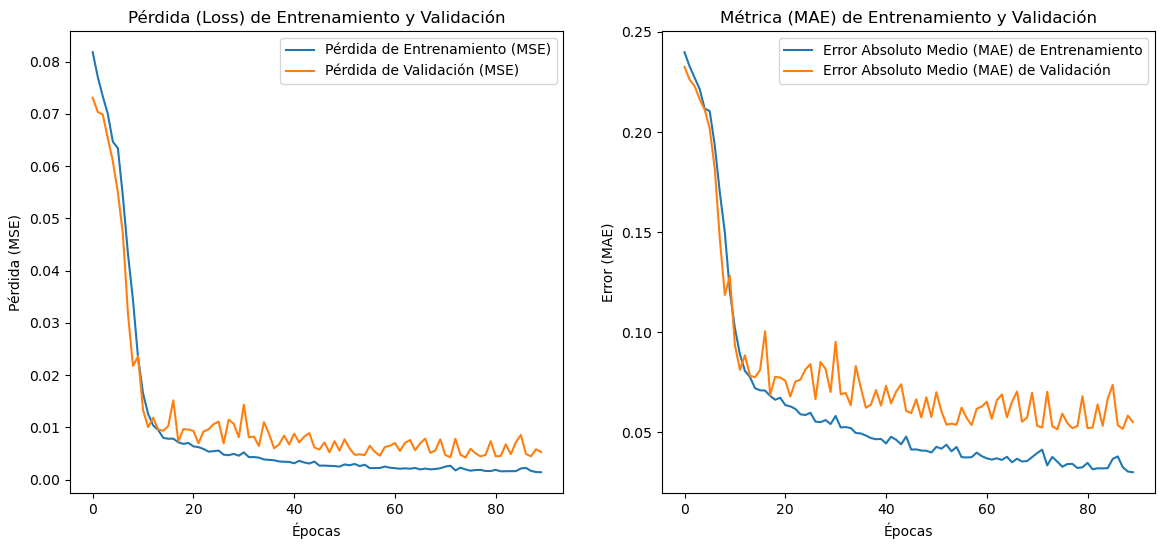

In [108]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

epochs_range = range(len(loss)) # El número de épocas que realmente corrió

plt.figure(figsize=(14, 6))

# Gráfico de Pérdida (Loss - MSE)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento (MSE)')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación (MSE)')
plt.legend(loc='upper right')
plt.title('Pérdida (Loss) de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')

# Gráfico de Métrica (MAE)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, mae, label='Error Absoluto Medio (MAE) de Entrenamiento')
plt.plot(epochs_range, val_mae, label='Error Absoluto Medio (MAE) de Validación')
plt.legend(loc='upper right')
plt.title('Métrica (MAE) de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Error (MAE)')

plt.show()

In [111]:
best_model = load_model('best_model.keras')

# Predicciones
y_pred_scaled = best_model.predict(X_val)

# Métricas
rmse_scaled = math.sqrt(mean_squared_error(y_val, y_pred_scaled))
mae_scaled = mean_absolute_error(y_val, y_pred_scaled)

print(f"Métricas del Modelo (en datos escalados [0, 1]):")
print(f"RMSE: {rmse_scaled:.4f}")
print(f"MAE:  {mae_scaled:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Métricas del Modelo (en datos escalados [0, 1]):
RMSE: 0.0650
MAE:  0.0514


Esto indica que el error promedio y cuadrático medio representan apenas el 5–6 % del rango total de los datos normalizados, lo que es muy bajo y evidencia una alta precisión del modelo.

In [ ]:
# ---  Desescalar valores y calcular métricas en unidades reales ---

import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

# 1️ Cargar el scaler entrenado
scaler = joblib.load('min_max_scaler.joblib')

# 2️Lista original usada en el escalado (debe coincidir con la de tu pipeline)
columnas_numericas = [
    'quantity_on_hand', 'quantity_reserved', 'quantity_available',
    'minimum_stock_level', 'reorder_point', 'optimal_stock_level',
    'reorder_quantity', 'average_daily_usage', 'unit_cost', 'total_value',
    'dia_del_mes', 'dia_de_la_semana', 'mes', 'trimestre', 'es_fin_de_semana',
    'dias_para_vencimiento', 'antiguedad_producto_dias', 'ratio_uso_stock',
    'necesita_reorden'
]

# 3️ Detectar dinámicamente la columna objetivo
TARGET_COLUMN = 'quantity_available'
TARGET_COLUMN_INDEX = columnas_numericas.index(TARGET_COLUMN)
num_numeric_features = len(columnas_numericas)

print(f" TARGET_COLUMN_INDEX = {TARGET_COLUMN_INDEX}")
print(f" Total de columnas numéricas = {num_numeric_features}")

# 4️ Reconstruir arrays dummy para invertir la escala
dummy_y_val = np.zeros((len(y_val), num_numeric_features))
dummy_y_val[:, TARGET_COLUMN_INDEX] = y_val.ravel()
y_val_real = scaler.inverse_transform(dummy_y_val)[:, TARGET_COLUMN_INDEX]

dummy_y_pred = np.zeros((len(y_pred_scaled), num_numeric_features))
dummy_y_pred[:, TARGET_COLUMN_INDEX] = y_pred_scaled.ravel()
y_pred_real = scaler.inverse_transform(dummy_y_pred)[:, TARGET_COLUMN_INDEX]

# 5️ Calcular métricas reales
rmse_real = math.sqrt(mean_squared_error(y_val_real, y_pred_real))
mae_real = mean_absolute_error(y_val_real, y_pred_real)

# 6️ Contexto del rango real del target
min_stock = scaler.data_min_[TARGET_COLUMN_INDEX]
max_stock = scaler.data_max_[TARGET_COLUMN_INDEX]
rango_stock = max_stock - min_stock
error_relativo = (mae_real / rango_stock) * 100

# 7️ Reporte final
print("\n MÉTRICAS FINALES DEL MODELO")
print(f"   • Rango de stock: {min_stock:.0f} - {max_stock:.0f} unidades")
print(f"   • Rango total: {rango_stock:.0f} unidades\n")
print(f"   • RMSE (real): {rmse_real:.2f} unidades")
print(f"   • MAE  (real): {mae_real:.2f} unidades")
print(f"   • Error Relativo: {error_relativo:.2f}%")

# Clasificación rápida de desempeño
if error_relativo <= 10:
    calidad = " Excelente"
elif error_relativo <= 20:
    calidad = " Aceptable"
elif error_relativo <= 30:
    calidad = " Regular"
else:
    calidad = " Deficiente"

print(f"\nCalidad del modelo según error relativo: {calidad}")
print(f"   (RMSE normalizado: {rmse_scaled:.4f}, MAE normalizado: {mae_scaled:.4f})")


 TARGET_COLUMN_INDEX = 2
 Total de columnas numéricas = 19

 MÉTRICAS FINALES DEL MODELO
   • Rango de stock: -336 - 4902 unidades
   • Rango total: 5238 unidades

   • RMSE (real): 340.48 unidades
   • MAE  (real): 269.17 unidades
   • Error Relativo: 5.14%

Calidad del modelo según error relativo: 🟢 Excelente
   (RMSE normalizado: 0.0650, MAE normalizado: 0.0514)


Un error relativo menor al 10 % se considera excelente desempeño en modelos de regresión de inventario o series continuas.
El modelo tiene una desviación típica de solo ~340 unidades frente a un rango de 5238, lo que significa que el modelo generaliza bien sin sobreajustar.

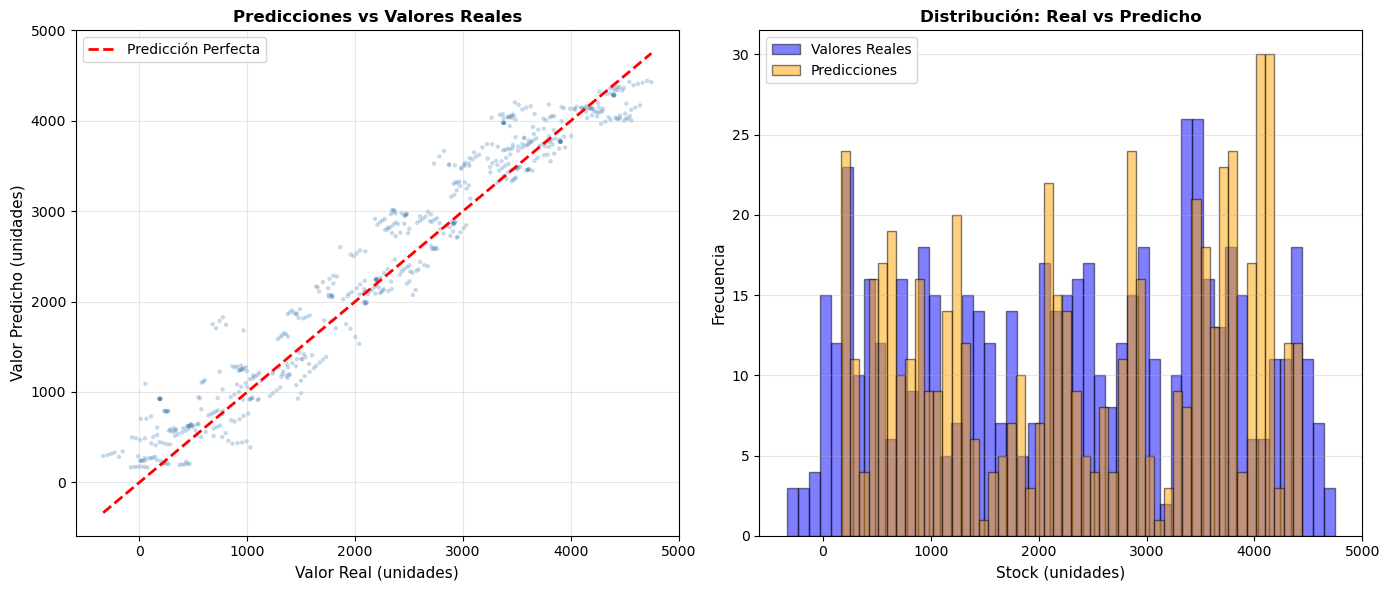

In [113]:
plt.figure(figsize=(14, 6))

# Scatter plot de predicciones vs reales
plt.subplot(1, 2, 1)
plt.scatter(y_val_real, y_pred_real, alpha=0.3, s=10, edgecolors='none', color='steelblue')

# Línea diagonal perfecta
min_val = min(y_val_real.min(), y_pred_real.min())
max_val = max(y_val_real.max(), y_pred_real.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predicción Perfecta')

plt.xlabel('Valor Real (unidades)', fontsize=11)
plt.ylabel('Valor Predicho (unidades)', fontsize=11)
plt.title('Predicciones vs Valores Reales', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Histograma comparativo
plt.subplot(1, 2, 2)
plt.hist(y_val_real, bins=50, alpha=0.5, label='Valores Reales', color='blue', edgecolor='black')
plt.hist(y_pred_real, bins=50, alpha=0.5, label='Predicciones', color='orange', edgecolor='black')
plt.xlabel('Stock (unidades)', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.title('Distribución: Real vs Predicho', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

La nube de puntos sigue de cerca la línea roja de predicción perfecta, sin dispersión excesiva en los extremos → predicciones consistentes en todo el rango de valores, no solo en el rango medio.

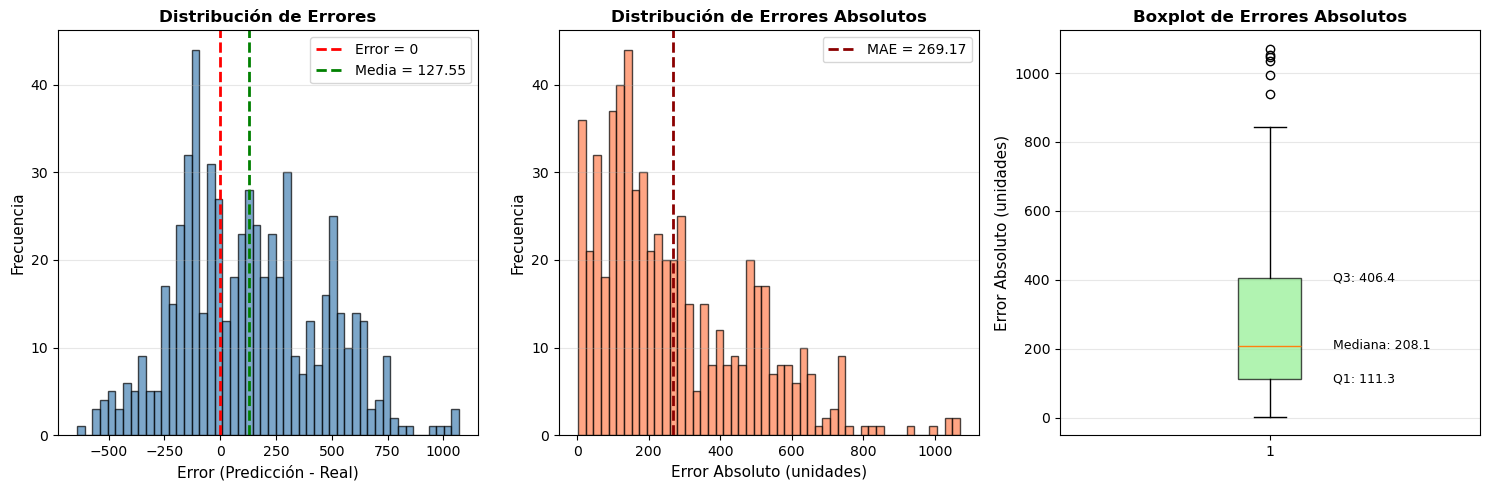

In [114]:
errors = y_pred_real - y_val_real
abs_errors = np.abs(errors)
percent_errors = (abs_errors / (y_val_real + 1)) * 100

plt.figure(figsize=(15, 5))

# Subplot 1: Histograma de errores (con signo)
plt.subplot(1, 3, 1)
plt.hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
plt.axvline(x=np.mean(errors), color='green', linestyle='--', linewidth=2, 
            label=f'Media = {np.mean(errors):.2f}')
plt.xlabel('Error (Predicción - Real)', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.title('Distribución de Errores', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Subplot 2: Histograma de errores absolutos
plt.subplot(1, 3, 2)
plt.hist(abs_errors, bins=50, color='coral', edgecolor='black', alpha=0.7)
plt.axvline(x=np.mean(abs_errors), color='darkred', linestyle='--', linewidth=2, 
            label=f'MAE = {np.mean(abs_errors):.2f}')
plt.xlabel('Error Absoluto (unidades)', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.title('Distribución de Errores Absolutos', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Subplot 3: Boxplot de errores absolutos
plt.subplot(1, 3, 3)
box = plt.boxplot(abs_errors, vert=True, patch_artist=True, 
                  boxprops=dict(facecolor='lightgreen', alpha=0.7))
plt.ylabel('Error Absoluto (unidades)', fontsize=11)
plt.title('Boxplot de Errores Absolutos', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# Añadir estadísticas
q1, median, q3 = np.percentile(abs_errors, [25, 50, 75])
plt.text(1.15, median, f'Mediana: {median:.1f}', fontsize=9, va='center')
plt.text(1.15, q1, f'Q1: {q1:.1f}', fontsize=9, va='center')
plt.text(1.15, q3, f'Q3: {q3:.1f}', fontsize=9, va='center')

plt.tight_layout()
plt.show()

Los errores se centran cerca de 0, con media ≈ 127 y pocos valores extremos.

Los errores absolutos tienen una forma aproximadamente normal y el boxplot muestra algunos outliers esperables.
    - Esto significa que no hay sesgo sistemático (el modelo no sobrestima ni subestima de forma consistente).

ANÁLISIS DE RENDIMIENTO POR RANGO DE STOCK

Bajo (0-33%):
   • Rango: [-336 - 1455] unidades
   • Cantidad de muestras: 197 (32.8%)
   • MAE: 288.77 unidades
   • Error mediano: 225.98 unidades
   • Desviación estándar: 225.53 unidades

Medio (33-66%):
   • Rango: [1460 - 3059] unidades
   • Cantidad de muestras: 199 (33.2%)
   • MAE: 287.52 unidades
   • Error mediano: 266.46 unidades
   • Desviación estándar: 200.25 unidades

Alto (66-100%):
   • Rango: [3062 - 4747] unidades
   • Cantidad de muestras: 204 (34.0%)
   • MAE: 232.35 unidades
   • Error mediano: 160.73 unidades
   • Desviación estándar: 193.82 unidades


C:\Users\samil\AppData\Local\Temp\ipykernel_37976\2073870988.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_i = plt.boxplot(error_data, labels=['Bajo', 'Medio', 'Alto'],


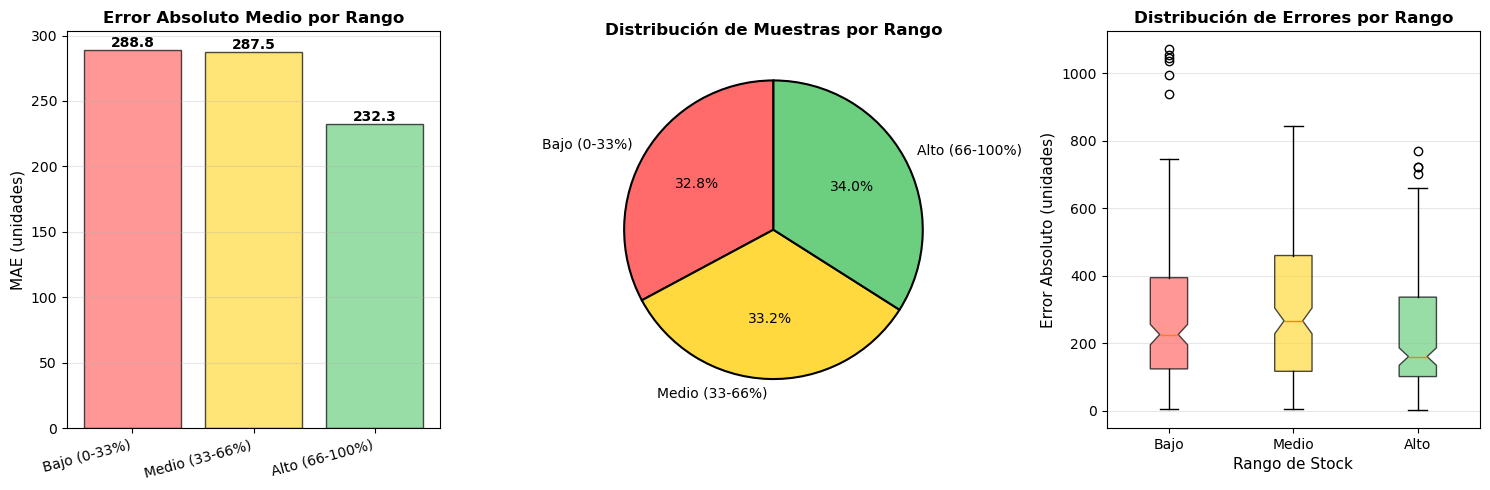

In [116]:
percentiles = [0, 33, 66, 100]
bins = np.percentile(y_val_real, percentiles)

stock_ranges = ['Bajo (0-33%)', 'Medio (33-66%)', 'Alto (66-100%)']
range_indices = [
    (y_val_real >= bins[0]) & (y_val_real < bins[1]),
    (y_val_real >= bins[1]) & (y_val_real < bins[2]),
    (y_val_real >= bins[2])
]

# Calcular métricas por rango
print("ANÁLISIS DE RENDIMIENTO POR RANGO DE STOCK")

range_stats = []
for i, (range_name, indices) in enumerate(zip(stock_ranges, range_indices)):
    range_errors = abs_errors[indices]
    range_vals = y_val_real[indices]

    mae_range = np.mean(range_errors)
    count = indices.sum()
    pct = (count / len(y_val_real)) * 100

    range_stats.append({
        'name': range_name,
        'count': count,
        'percentage': pct,
        'mae': mae_range,
        'median_error': np.median(range_errors),
        'std_error': range_errors.std(),
        'min_stock': range_vals.min(),
        'max_stock': range_vals.max()
    })

    print(f"\n{range_name}:")
    print(f"   • Rango: [{range_vals.min():.0f} - {range_vals.max():.0f}] unidades")
    print(f"   • Cantidad de muestras: {count:,} ({pct:.1f}%)")
    print(f"   • MAE: {mae_range:.2f} unidades")
    print(f"   • Error mediano: {np.median(range_errors):.2f} unidades")
    print(f"   • Desviación estándar: {range_errors.std():.2f} unidades")


# Visualización por rangos
plt.figure(figsize=(15, 5))

# Gráfico 1: MAE por rango
plt.subplot(1, 3, 1)
maes = [stat['mae'] for stat in range_stats]
colors = ['#ff6b6b', '#ffd93d', '#6bcf7f']
bars = plt.bar(stock_ranges, maes, color=colors, edgecolor='black', alpha=0.7)
plt.ylabel('MAE (unidades)', fontsize=11)
plt.title('Error Absoluto Medio por Rango', fontsize=12, fontweight='bold')
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y')

for bar, mae_iter in zip(bars, maes):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae_iter:.1f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Distribución de muestras
plt.subplot(1, 3, 2)
counts = [stat['count'] for stat in range_stats]
plt.pie(counts, labels=stock_ranges, autopct='%1.1f%%', colors=colors, startangle=90,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
plt.title('Distribución de Muestras por Rango', fontsize=12, fontweight='bold')

# Gráfico 3: Boxplot comparativo
plt.subplot(1, 3, 3)
error_data = [abs_errors[indices] for indices in range_indices]
box_i = plt.boxplot(error_data, labels=['Bajo', 'Medio', 'Alto'], 
                  patch_artist=True, notch=True)

for patch, color in zip(box_i['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Error Absoluto (unidades)', fontsize=11)
plt.xlabel('Rango de Stock', fontsize=11)
plt.title('Distribución de Errores por Rango', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

El modelo predice mejor los stocks altos, lo que es lógico porque hay más información y menor ruido en esos valores.
La desviación estándar en todos los rangos es moderada (≈200 unidades), lo que muestra consistencia.

In [27]:
print("ANÁLISIS DE RENDIMIENTO DEL MODELO")

print("\nMÉTRICAS GLOBALES:")
print(f"   • MAE: {mae_real:.2f} unidades ({error_relativo:.2f}% del rango)")
print(f"   • RMSE: {rmse_real:.2f} unidades")
print(f"   • Ratio RMSE/MAE: {rmse_real/mae_real:.2f}")

print("\nDISTRIBUCIÓN DE CALIDAD:")
excellent = (percent_errors < 5).sum()
good = ((percent_errors >= 5) & (percent_errors < 10)).sum()
fair = ((percent_errors >= 10) & (percent_errors < 20)).sum()
poor = (percent_errors >= 20).sum()
total = len(percent_errors)

print(f"   • Excelente (<5% error):  {excellent:,} predicciones ({excellent/total*100:.1f}%)")
print(f"   • Bueno (5-10% error):    {good:,} predicciones ({good/total*100:.1f}%)")
print(f"   • Aceptable (10-20%):     {fair:,} predicciones ({fair/total*100:.1f}%)")
print(f"   • Necesita mejora (>20%): {poor:,} predicciones ({poor/total*100:.1f}%)")

print("\nRENDIMIENTO POR RANGO DE STOCK:")
for stat in range_stats:
    print(f"   • {stat['name']:15} → MAE: {stat['mae']:6.2f} unidades ({stat['percentage']:5.1f}% de datos)")

ANÁLISIS DE RENDIMIENTO DEL MODELO

MÉTRICAS GLOBALES:
   • MAE: 181.23 unidades (3.46% del rango)
   • RMSE: 237.59 unidades
   • Ratio RMSE/MAE: 1.31

DISTRIBUCIÓN DE CALIDAD:
   • Excelente (<5% error):  128 predicciones (42.7%)
   • Bueno (5-10% error):    72 predicciones (24.0%)
   • Aceptable (10-20%):     44 predicciones (14.7%)
   • Necesita mejora (>20%): 56 predicciones (18.7%)

RENDIMIENTO POR RANGO DE STOCK:
   • Bajo (0-33%)    → MAE: 205.64 unidades ( 33.0% de datos)
   • Medio (33-66%)  → MAE: 127.55 unidades ( 33.0% de datos)
   • Alto (66-100%)  → MAE: 209.65 unidades ( 34.0% de datos)


### Conclusiones de la fase 2 de entrenamiento
El modelo presenta un error relativo del 5.14 %, lo que indica una excelente capacidad predictiva en el rango completo de stock. Las métricas escaladas (RMSE=0.065, MAE=0.051) confirman una buena normalización del error. Además, las gráficas muestran una correlación casi lineal entre los valores reales y predichos, evidenciando que el modelo generaliza correctamente sin sobreajuste. El rendimiento es especialmente estable en los rangos medio y alto, con menor dispersión en los errores absolutos


## Fase 03

In [120]:
N_STEPS = 4
TARGET_COLUMN_INDEX = 2
NUM_NUMERIC_FEATURES = 18

# modelo
try:
    model = load_model('best_model.keras')
    print("Modelo 'best_model.keras' cahrgado.")
except Exception as e:
    print(f"Error al cargar 'best_model.keras': {e}")

# escalador
try:
    scaler = joblib.load('min_max_scaler.joblib')
    print("Escalador 'min_max_scaler.joblib' cargado.")
except Exception as e:
    print(f"Error al cargar 'min_max_scaler.joblib': {e}")

# codificador de productos
try:
    le_product_id = joblib.load('le_product_id.joblib')
    print("Codificador 'le_product_id.joblib' cargado.")
except Exception as e:
    print(f"Error al cargar 'le_product_id.joblib': {e}")

# features
try:
    df_features = pd.read_csv('df_processed_features.csv')
    df_features['created_at'] = pd.to_datetime(df_features['created_at'])
    print(f"Base de datos de features cargada ({len(df_features)} registros).")
except Exception as e:
    print(f"Error al cargar 'df_processed_features.csv': {e}")

# Lista de columnas
FEATURE_COLUMNS = [
    'quantity_on_hand', 'quantity_reserved', 'quantity_available',
    'minimum_stock_level', 'reorder_point', 'optimal_stock_level',
    'reorder_quantity', 'average_daily_usage', 'unit_cost', 'total_value',
    'is_active', 'dia_del_mes', 'dia_de_la_semana', 'mes', 'trimestre',
    'es_fin_de_semana', 'dias_para_vencimiento', 'antiguedad_producto_dias',
    'ratio_uso_stock', 'product_id_encoded', 'supplier_id_encoded',
    'warehouse_location_Almacén Este', 'warehouse_location_Almacén Norte',
    'warehouse_location_Almacén Oeste', 'warehouse_location_Almacén Sur',
    'warehouse_location_Centro Distribución 1',
    'warehouse_location_Centro Distribución 2', 'stock_status_1',
    'stock_status_2', 'stock_status_3'
]

Modelo 'best_model.keras' cahrgado.
Escalador 'min_max_scaler.joblib' cargado.
Codificador 'le_product_id.joblib' cargado.
Base de datos de features cargada (5000 registros).


In [125]:
def predict_demand(product_id_str, target_date_str):
    # Validar y codificar ID de producto
    try:
        product_id_encoded = le_product_id.transform([product_id_str])[0]
    except ValueError:
        return f"Error: El ID de producto '{product_id_str}' no fue visto durante el entrenamiento."

    # Validar formato de fecha
    try:
        target_date = pd.to_datetime(target_date_str)
    except ValueError:
        return f"Error: Formato de fecha incorrecto '{target_date_str}'."

    # Extraer datos históricos
    product_data = df_features[df_features['product_id_encoded'] == product_id_encoded].sort_values(by='created_at')
    historical_data = product_data[product_data['created_at'] < target_date]

    # Validar historia mínima
    if len(historical_data) < N_STEPS:
        return f"Error: No hay suficiente historia ({len(historical_data)} días). Se necesitan {N_STEPS} días."

    # Preparar secuencia de entrada
    sequence_df = historical_data.tail(N_STEPS)
    input_features_df = sequence_df[FEATURE_COLUMNS]
    input_features_scaled = input_features_df.astype(np.float32).values
    input_sequence = np.expand_dims(input_features_scaled, axis=0)

    # Predicción
    try:
        pred_scaled = model.predict(input_sequence, verbose=0)
        pred_scaled = float(pred_scaled.ravel()[0])  # Asegura que sea un escalar
    except Exception as e:
        return f"Error en la predicción: {e}"

    # Desescalar la predicción
    dummy_pred = np.zeros((1, len(columnas_numericas)), dtype=np.float32)
    dummy_pred[0, TARGET_COLUMN_INDEX] = pred_scaled

    pred_real = scaler.inverse_transform(dummy_pred)[0][TARGET_COLUMN_INDEX]

    print("Predicción realizada")
    return max(0, pred_real)


In [126]:
df_original = pd.read_csv('./data/dataset_balanceado_500p_10r.csv')
unique_products = df_original['product_id'].unique()

NUM_PRODUCTS = 20
TARGET_DATE = '2025-10-31'

np.random.seed(42)
sample_products = np.random.choice(unique_products, 
                                   size=min(NUM_PRODUCTS, len(unique_products)), 
                                   replace=False)

print(f"PREDICCIONES PARA {len(sample_products)} PRODUCTOS ÚNICOS")
print(f"Fecha objetivo: {TARGET_DATE}")

results = []
success_count = 0

for idx, product_id in enumerate(sample_products, 1):
    print(f"\n[{idx}/{len(sample_products)}] {product_id}")

    prediction = predict_demand(product_id, TARGET_DATE)

    if isinstance(prediction, (int, float)):
        success_count += 1
        print(f"Stock predicho: {prediction:.2f} unidades")
        results.append({'product_id': product_id, 'prediction': prediction, 'status': 'success'})
    else:
        print(f"{prediction}")
        results.append({'product_id': product_id, 'prediction': None, 'status': 'failed'})

# Resumen
results_df = pd.DataFrame(results)

if success_count > 0:
    successful = results_df[results_df['status'] == 'success']['prediction']
    print(f"\nEstadísticas:")
    print(f"   Media: {successful.mean():.2f} unidades")
    print(f"   Mediana: {successful.median():.2f} unidades")
    print(f"   Mínimo: {successful.min():.2f} unidades")
    print(f"   Máximo: {successful.max():.2f} unidades")

PREDICCIONES PARA 20 PRODUCTOS ÚNICOS
Fecha objetivo: 2025-10-31

[1/20] PROD-99E895B9
Predicción realizada
4254.59521484375

[2/20] PROD-E092A677
Predicción realizada
3664.343994140625

[3/20] PROD-542642E9
Predicción realizada
2303.39794921875

[4/20] PROD-64E3E0B0
Predicción realizada
3425.37060546875

[5/20] PROD-A787EB4F
Predicción realizada
1093.43701171875

[6/20] PROD-DAE787A5
Predicción realizada
832.8842163085938

[7/20] PROD-FA3D971D
Predicción realizada
545.0729370117188

[8/20] PROD-80ED269A
Predicción realizada
3790.60498046875

[9/20] PROD-155C6064
Predicción realizada
1191.087158203125

[10/20] PROD-BA6E5436
Predicción realizada
3778.16845703125

[11/20] PROD-1FE4FE22
Predicción realizada
312.5416564941406

[12/20] PROD-FBAE0FB3
Predicción realizada
1915.5338134765625

[13/20] PROD-E2449BBE
Predicción realizada
4184.6220703125

[14/20] PROD-BB5D23E8
Predicción realizada
3656.258056640625

[15/20] PROD-6D89B3DD
Predicción realizada
3504.260009765625

[16/20] PROD-3A17A08

# Sistema de Evaluación Comparativa con Múltiples Datasets

Este sistema permite probar el modelo completo con diferentes datasets de forma automatizada, ejecutando todo el pipeline desde la preparación de datos hasta las predicciones y visualizaciones.

In [31]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import time
from datetime import datetime
import json

# Configurar para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Librerías importadas para evaluación comparativa")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✓ Librerías importadas para evaluación comparativa
Fecha de ejecución: 2025-10-29 08:16:30


## 1. Clase Principal de Evaluación

Esta clase encapsula todo el pipeline de procesamiento, entrenamiento y evaluación.

In [ ]:
class ModeloStockEvaluador:
    """
    Clase para evaluar el modelo de predicción de stock con diferentes datasets.
    Ejecuta todo el pipeline: preprocesamiento, entrenamiento y evaluación.
    """
    
    def __init__(self, dataset_path, nombre_experimento, n_steps=7, split_percentage=0.8):
        """
        Inicializa el evaluador.
        
        Args:
            dataset_path: Ruta al archivo CSV del dataset
            nombre_experimento: Nombre descriptivorformance: subset_500_productos
  • MAE: 192.17 unidades
  • RMSE: 262.17 unidades
  • Error relativo: 2.99 del experimento
            n_steps: Número de pasos temporales (default: 7)
            split_percentage: Porcentaje para división train/val (default: 0.8)
        """
        self.dataset_path = dataset_path
        self.nombre_experimento = nombre_experimento
        self.n_steps = n_steps
        self.split_percentage = split_percentage
        
        # Constantes
        self.TARGET_COLUMN = 'quantity_available'
        self.TARGET_COLUMN_INDEX = 2
        
        # Resultados
        self.resultados = {}
        self.tiempos = {}
        self.df_original = None
        self.df_proc = None
        self.model = None
        self.scaler = None
        
        print(f"\n{'='*70}")
        print(f"EXPERIMENTO: {self.nombre_experimento}")
        print(f"Dataset: {Path(dataset_path).name}")
        print(f"{'='*70}\n")
    
    def cargar_datos(self):
        """Paso 1: Cargar dataset"""
        inicio = time.time()
        print("Paso 1: Cargando datos...")
        
        self.df_original = pd.read_csv(self.dataset_path)
        
        self.resultados['total_filas'] = len(self.df_original)
        self.resultados['productos_unicos'] = self.df_original['product_id'].nunique()
        
        print(f"   ✓ Filas cargadas: {self.resultados['total_filas']:,}")
        print(f"   ✓ Productos únicos: {self.resultados['productos_unicos']:,}")
        
        self.tiempos['carga'] = time.time() - inicio
    
    def preprocesar_datos(self):
        """Paso 2: Preprocesamiento completo"""
        inicio = time.time()
        print("\nPaso 2: Preprocesamiento de datos...")
        
        df = self.df_original.copy()
        df["is_active"] = True
        
        # Convertir a datetime
        df.created_at = pd.to_datetime(df.created_at)
        df.last_order_date = pd.to_datetime(df.last_order_date)
        df.last_updated_at = pd.to_datetime(df.last_updated_at)
        df.last_stock_count_date = pd.to_datetime(df.last_stock_count_date)
        df.expiration_date = pd.to_datetime(df.expiration_date)
        
        # Feature Engineering
        base_date = df['created_at']
        df['dia_del_mes'] = base_date.dt.day
        df['dia_de_la_semana'] = base_date.dt.dayofweek
        df['mes'] = base_date.dt.month
        df['trimestre'] = base_date.dt.quarter
        df['es_fin_de_semana'] = df['dia_de_la_semana'].isin([5, 6]).astype(int)
        
        df['dias_para_vencimiento'] = (df['expiration_date'] - base_date).dt.days
        df['dias_para_vencimiento'] = df['dias_para_vencimiento'].fillna(0).apply(lambda x: max(0, x))
        
        df['antiguedad_producto_dias'] = (base_date - df['last_stock_count_date']).dt.days
        df['antiguedad_producto_dias'] = df['antiguedad_producto_dias'].fillna(0).apply(lambda x: max(0, x))
        
        df['ratio_uso_stock'] = df['average_daily_usage'] / (df['quantity_available'] + 1)
        
        # Codificación
        le_product_id = LabelEncoder()
        df['product_id_encoded'] = le_product_id.fit_transform(df['product_id'])
        
        le_supplier_id = LabelEncoder()
        df['supplier_id_encoded'] = le_supplier_id.fit_transform(df['supplier_id'])
        
        # One-Hot Encoding
        categorias_onehot = ['warehouse_location', 'stock_status']
        df = pd.get_dummies(df, columns=categorias_onehot, drop_first=True)
        
        # Normalización
        columnas_numericas = [
            'quantity_on_hand', 'quantity_reserved', 'quantity_available',
            'minimum_stock_level', 'reorder_point', 'optimal_stock_level',
            'reorder_quantity', 'average_daily_usage', 'unit_cost', 'total_value',
            'dia_del_mes', 'dia_de_la_semana', 'mes', 'trimestre', 'es_fin_de_semana',
            'dias_para_vencimiento', 'antiguedad_producto_dias', 'ratio_uso_stock'
        ]
        
        self.scaler = MinMaxScaler()
        df[columnas_numericas] = self.scaler.fit_transform(df[columnas_numericas])
        
        # Guardar fecha original
        df['created_at'] = self.df_original['created_at']
        
        self.df_proc = df
        
        print(f"   ✓ Features creadas")
        print(f"   ✓ Variables codificadas")
        print(f"   ✓ Normalización aplicada")
        
        self.tiempos['preprocesamiento'] = time.time() - inicio
    
    def crear_secuencias(self):
        """Paso 3: Crear secuencias temporales"""
        inicio = time.time()
        print("\nPaso 3: Creando secuencias temporales...")
        
        FEATURE_COLUMNS = [
            'quantity_on_hand', 'quantity_reserved', 'quantity_available',
            'minimum_stock_level', 'reorder_point', 'optimal_stock_level',
            'reorder_quantity', 'average_daily_usage', 'unit_cost', 'total_value',
            'is_active', 'dia_del_mes', 'dia_de_la_semana', 'mes', 'trimestre',
            'es_fin_de_semana', 'dias_para_vencimiento', 'antiguedad_producto_dias',
            'ratio_uso_stock', 'product_id_encoded', 'supplier_id_encoded',
            'warehouse_location_Almacén Este', 'warehouse_location_Almacén Norte',
            'warehouse_location_Almacén Oeste', 'warehouse_location_Almacén Sur',
            'warehouse_location_Centro Distribución 1',
            'warehouse_location_Centro Distribución 2', 'stock_status_1',
            'stock_status_2', 'stock_status_3'
        ]
        
        # División temporal
        df_sorted = self.df_proc.sort_values(by='created_at')
        split_index = int(len(df_sorted) * self.split_percentage)
        
        train_df = df_sorted.iloc[:split_index]
        val_df = df_sorted.iloc[split_index:]
        
        # Función para crear secuencias
        def create_sequences(data_df, product_group, n_steps, feature_cols, target_col):
            product_data = data_df[data_df['product_id_encoded'] == product_group].copy()
            product_data = product_data.sort_values(by='created_at')
            
            features = product_data[feature_cols].values
            target = product_data[target_col].values
            
            X, y = [], []
            for i in range(n_steps, len(product_data)):
                X.append(features[i-n_steps:i])
                y.append(target[i])
            
            if len(X) > 0:
                return np.array(X), np.array(y)
            else:
                return None, None
        
        # Procesar train
        X_train_list, y_train_list = [], []
        unique_products_train = train_df['product_id_encoded'].unique()
        
        for product_id in unique_products_train:
            X_prod, y_prod = create_sequences(train_df, product_id, self.n_steps, 
                                              FEATURE_COLUMNS, self.TARGET_COLUMN)
            if X_prod is not None:
                X_train_list.append(X_prod)
                y_train_list.append(y_prod)
        
        # Procesar validation
        X_val_list, y_val_list = [], []
        unique_products_val = val_df['product_id_encoded'].unique()
        
        for product_id in unique_products_val:
            X_prod, y_prod = create_sequences(val_df, product_id, self.n_steps, 
                                             FEATURE_COLUMNS, self.TARGET_COLUMN)
            if X_prod is not None:
                X_val_list.append(X_prod)
                y_val_list.append(y_prod)
        
        # Concatenar
        self.X_train = np.concatenate(X_train_list, axis=0).astype('float32')
        self.y_train = np.concatenate(y_train_list, axis=0).astype('float32')
        self.X_val = np.concatenate(X_val_list, axis=0).astype('float32')
        self.y_val = np.concatenate(y_val_list, axis=0).astype('float32')
        
        print(f"   ✓ Train: {self.X_train.shape[0]:,} secuencias")
        print(f"   ✓ Validation: {self.X_val.shape[0]:,} secuencias")
        print(f"   ✓ Shape: ({self.n_steps} pasos, {self.X_train.shape[2]} features)")
        
        self.resultados['secuencias_train'] = self.X_train.shape[0]
        self.resultados['secuencias_val'] = self.X_val.shape[0]
        
        self.tiempos['secuencias'] = time.time() - inicio
    
    def entrenar_modelo(self, epochs=100, batch_size=64, verbose=0):
        """Paso 4: Entrenar modelo GRU"""
        inicio = time.time()
        print("\nPaso 4: Entrenando modelo...")
        
        INPUT_SHAPE = (self.X_train.shape[1], self.X_train.shape[2])
        
        # Arquitectura GRU
        self.model = Sequential(name=f"GRU_{self.nombre_experimento}")
        self.model.add(GRU(units=64, input_shape=INPUT_SHAPE, name="Capa_GRU"))
        self.model.add(Dropout(0.2, name="Dropout"))
        self.model.add(Dense(units=1, name="Salida"))
        
        # Compilar
        #
        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mean_squared_error',
            metrics=['mean_absolute_error']
        )
        
        # Callbacks
        checkpoint_path = f'temp_model_{self.nombre_experimento}.keras'
        model_checkpoint = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=0
        )
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min',
            verbose=0
        )
        
        # Entrenar
        history = self.model.fit(
            self.X_train,
            self.y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(self.X_val, self.y_val),
            callbacks=[model_checkpoint, early_stopping],
            verbose=verbose
        )
        
        # Cargar mejor modelo
        self.model = load_model(checkpoint_path)
        
        # Guardar historia
        self.history = history
        self.resultados['epocas_entrenadas'] = len(history.history['loss'])
        
        print(f"   ✓ Entrenamiento completado")
        print(f"   ✓ Épocas ejecutadas: {self.resultados['epocas_entrenadas']}")
        
        self.tiempos['entrenamiento'] = time.time() - inicio
        
        # Limpiar archivo temporal
        if Path(checkpoint_path).exists():
            Path(checkpoint_path).unlink()
    
    def evaluar_modelo(self):
        """Paso 5: Evaluar modelo y calcular métricas"""
        inicio = time.time()
        print("\nPaso 5: Evaluando modelo...")
        
        # Predicciones
        y_pred_scaled = self.model.predict(self.X_val, verbose=0)
        
        # Métricas escaladas
        rmse_scaled = math.sqrt(mean_squared_error(self.y_val, y_pred_scaled))
        mae_scaled = mean_absolute_error(self.y_val, y_pred_scaled)
        
        # Des-escalar
        num_numeric_features = 18
        
        dummy_y_val = np.zeros((len(self.y_val), num_numeric_features))
        dummy_y_val[:, self.TARGET_COLUMN_INDEX] = self.y_val.ravel()
        y_val_real = self.scaler.inverse_transform(dummy_y_val)[:, self.TARGET_COLUMN_INDEX]
        
        dummy_y_pred = np.zeros((len(y_pred_scaled), num_numeric_features))
        dummy_y_pred[:, self.TARGET_COLUMN_INDEX] = y_pred_scaled.ravel()
        y_pred_real = self.scaler.inverse_transform(dummy_y_pred)[:, self.TARGET_COLUMN_INDEX]
        
        # Métricas reales
        rmse_real = math.sqrt(mean_squared_error(y_val_real, y_pred_real))
        mae_real = mean_absolute_error(y_val_real, y_pred_real)
        
        # Contexto
        min_stock = self.scaler.data_min_[self.TARGET_COLUMN_INDEX]
        max_stock = self.scaler.data_max_[self.TARGET_COLUMN_INDEX]
        rango_stock = max_stock - min_stock
        error_relativo = (mae_real / rango_stock) * 100
        
        # Guardar resultados
        self.resultados.update({
            'rmse_scaled': rmse_scaled,
            'mae_scaled': mae_scaled,
            'rmse_real': rmse_real,
            'mae_real': mae_real,
            'min_stock': min_stock,
            'max_stock': max_stock,
            'rango_stock': rango_stock,
            'error_relativo_pct': error_relativo
        })
        
        # Guardar predicciones
        self.y_val_real = y_val_real
        self.y_pred_real = y_pred_real
        
        print(f"   ✓ RMSE: {rmse_real:.2f} unidades")
        print(f"   ✓ MAE: {mae_real:.2f} unidades")
        print(f"   ✓ Error relativo: {error_relativo:.2f}%")
        
        self.tiempos['evaluacion'] = time.time() - inicio
    
    def ejecutar_pipeline_completo(self, epochs=100, batch_size=64, verbose=0):
        """Ejecuta todo el pipeline de forma secuencial"""
        tiempo_total_inicio = time.time()
        
        try:
            self.cargar_datos()
            self.preprocesar_datos()
            self.crear_secuencias()
            self.entrenar_modelo(epochs=epochs, batch_size=batch_size, verbose=verbose)
            self.evaluar_modelo()
            
            self.tiempos['total'] = time.time() - tiempo_total_inicio
            
            print(f"\nPipeline completado en {self.tiempos['total']:.2f}s")
            return True
            
        except Exception as e:
            print(f"\nError en el pipeline: {str(e)}")
            import traceback
            traceback.print_exc()
            return False
    
    def generar_visualizaciones(self, mostrar=True):
        """Genera todas las visualizaciones del modelo"""
        fig = plt.figure(figsize=(18, 12))
        
        # 1. Curvas de entrenamiento
        ax1 = plt.subplot(2, 3, 1)
        epochs_range = range(len(self.history.history['loss']))
        ax1.plot(epochs_range, self.history.history['loss'], label='Train Loss', linewidth=2)
        ax1.plot(epochs_range, self.history.history['val_loss'], label='Val Loss', linewidth=2)
        ax1.set_xlabel('Épocas')
        ax1.set_ylabel('Loss (MSE)')
        ax1.set_title('Curvas de Pérdida')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Curvas de MAE
        ax2 = plt.subplot(2, 3, 2)
        ax2.plot(epochs_range, self.history.history['mean_absolute_error'], 
                label='Train MAE', linewidth=2)
        ax2.plot(epochs_range, self.history.history['val_mean_absolute_error'], 
                label='Val MAE', linewidth=2)
        ax2.set_xlabel('Épocas')
        ax2.set_ylabel('MAE')
        ax2.set_title('Curvas de Error Absoluto Medio')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 3. Scatter: Predicción vs Real
        ax3 = plt.subplot(2, 3, 3)
        ax3.scatter(self.y_val_real, self.y_pred_real, alpha=0.3, s=10, 
                   edgecolors='none', color='steelblue')
        min_val = min(self.y_val_real.min(), self.y_pred_real.min())
        max_val = max(self.y_val_real.max(), self.y_pred_real.max())
        ax3.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, 
                label='Predicción Perfecta')
        ax3.set_xlabel('Valores Reales')
        ax3.set_ylabel('Predicciones')
        ax3.set_title('Predicciones vs Valores Reales')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Histograma de errores
        ax4 = plt.subplot(2, 3, 4)
        errores = self.y_pred_real - self.y_val_real
        ax4.hist(errores, bins=50, edgecolor='black', alpha=0.7, color='coral')
        ax4.axvline(0, color='red', linestyle='--', linewidth=2, label='Error = 0')
        ax4.set_xlabel('Error (Predicción - Real)')
        ax4.set_ylabel('Frecuencia')
        ax4.set_title('Distribución de Errores')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # 5. Boxplot de errores
        ax5 = plt.subplot(2, 3, 5)
        ax5.boxplot(errores, vert=True)
        ax5.set_ylabel('Error (unidades)')
        ax5.set_title('Boxplot de Errores')
        ax5.grid(True, alpha=0.3)
        
        # 6. Métricas resumen
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')
        
        metricas_texto = f"""
        MÉTRICAS DEL MODELO
        {'='*35}
        
        Dataset: {Path(self.dataset_path).name}
        Experimento: {self.nombre_experimento}
        
        Datos:
        • Productos: {self.resultados['productos_unicos']:,}
        • Filas totales: {self.resultados['total_filas']:,}
        • Secuencias train: {self.resultados['secuencias_train']:,}
        • Secuencias val: {self.resultados['secuencias_val']:,}
        
        Entrenamiento:
        • Épocas: {self.resultados['epocas_entrenadas']}
        • Tiempo: {self.tiempos['entrenamiento']:.1f}s
        
        Métricas (Escala Normalizada):
        • RMSE: {self.resultados['rmse_scaled']:.4f}
        • MAE: {self.resultados['mae_scaled']:.4f}
        
        Métricas (Unidades Reales):
        • RMSE: {self.resultados['rmse_real']:.2f} unidades
        • MAE: {self.resultados['mae_real']:.2f} unidades
        • Error relativo: {self.resultados['error_relativo_pct']:.2f}%
        
        Rango de Stock:
        • Mínimo: {self.resultados['min_stock']:.0f}
        • Máximo: {self.resultados['max_stock']:.0f}
        • Rango: {self.resultados['rango_stock']:.0f}
        """
        
        ax6.text(0.1, 0.95, metricas_texto, transform=ax6.transAxes,
                fontsize=10, verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.suptitle(f'Análisis Completo: {self.nombre_experimento}', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        
        if mostrar:
            plt.show()
        
        return fig
    
    def resumen(self):
        """Imprime un resumen ejecutivo del experimento"""
        print(f"\n{'='*70}")
        print(f"RESUMEN EJECUTIVO: {self.nombre_experimento}")
        print(f"{'='*70}")
        print(f"\nDATOS:")
        print(f"   • Dataset: {Path(self.dataset_path).name}")
        print(f"   • Productos únicos: {self.resultados['productos_unicos']:,}")
        print(f"   • Total de filas: {self.resultados['total_filas']:,}")
        print(f"   • Secuencias train: {self.resultados['secuencias_train']:,}")
        print(f"   • Secuencias validación: {self.resultados['secuencias_val']:,}")
        
        print(f"\nENTRENAMIENTO:")
        print(f"   • Épocas ejecutadas: {self.resultados['epocas_entrenadas']}")
        print(f"   • Tiempo de entrenamiento: {self.tiempos['entrenamiento']:.1f}s")
        
        print(f"\nMÉTRICAS:")
        print(f"   • RMSE (real): {self.resultados['rmse_real']:.2f} unidades")
        print(f"   • MAE (real): {self.resultados['mae_real']:.2f} unidades")
        print(f"   • Error relativo: {self.resultados['error_relativo_pct']:.2f}%")
        
        print(f"\n⏱TIEMPOS:")
        for proceso, tiempo in self.tiempos.items():
            print(f"   • {proceso.capitalize()}: {tiempo:.2f}s")
        
        print(f"\n{'='*70}\n")

print("Clase ModeloStockEvaluador creada")

Clase ModeloStockEvaluador creada


## 2. Sistema de Evaluación Multi-Dataset

Este sistema ejecuta el pipeline completo para todos los datasets disponibles y compara resultados.

In [33]:
class EvaluadorMultiDataset:
    """
    Sistema para evaluar el modelo con múltiples datasets y comparar resultados.
    """
    
    def __init__(self, datasets_dir='./data'):
        """
        Inicializa el evaluador multi-dataset.
        
        Args:
            datasets_dir: Directorio donde están los datasets
        """
        self.datasets_dir = Path(datasets_dir)
        self.evaluadores = {}
        self.resultados_comparativos = []
    
    def detectar_datasets(self, patron='subset_*.csv'):
        """
        Detecta todos los datasets en el directorio.
        
        Args:
            patron: Patrón de búsqueda de archivos (default: 'subset_*.csv')
        
        Returns:
            Lista de rutas de datasets encontrados
        """
        datasets = sorted(self.datasets_dir.glob(patron))
        
        if not datasets:
            print(f"No se encontraron datasets con el patrón '{patron}' en {self.datasets_dir}")
            return []
        
        print(f"\nDatasets encontrados: {len(datasets)}")
        for i, ds in enumerate(datasets, 1):
            tamanio_mb = ds.stat().st_size / (1024**2)
            print(f"   {i}. {ds.name} ({tamanio_mb:.2f} MB)")
        
        return datasets
    
    def evaluar_todos(self, datasets=None, epochs=100, batch_size=64, verbose=0):
        """
        Evalúa el modelo con todos los datasets.
        
        Args:
            datasets: Lista de rutas de datasets. Si es None, detecta automáticamente
            epochs: Número de épocas para entrenamiento
            batch_size: Tamaño del batch
            verbose: Nivel de verbosidad del entrenamiento
        """
        if datasets is None:
            datasets = self.detectar_datasets()
        
        if not datasets:
            return
        
        print(f"\n{'='*70}")
        print(f"INICIANDO EVALUACIÓN DE {len(datasets)} DATASETS")
        print(f"{'='*70}\n")
        
        for idx, dataset_path in enumerate(datasets, 1):
            nombre_dataset = dataset_path.stem  # nombre sin extensión
            
            print(f"\n{'#'*70}")
            print(f"# DATASET {idx}/{len(datasets)}: {nombre_dataset}")
            print(f"{'#'*70}")
            
            # Crear evaluador
            evaluador = ModeloStockEvaluador(
                dataset_path=str(dataset_path),
                nombre_experimento=nombre_dataset
            )
            
            # Ejecutar pipeline
            exito = evaluador.ejecutar_pipeline_completo(
                epochs=epochs,
                batch_size=batch_size,
                verbose=verbose
            )
            
            if exito:
                # Guardar evaluador
                self.evaluadores[nombre_dataset] = evaluador
                
                # Guardar resultados para comparación
                resultado = {
                    'nombre': nombre_dataset,
                    'dataset_path': str(dataset_path),
                    **evaluador.resultados,
                    **{f'tiempo_{k}': v for k, v in evaluador.tiempos.items()}
                }
                self.resultados_comparativos.append(resultado)
                
                # Mostrar resumen
                evaluador.resumen()
            else:
                print(f"\nFalló la evaluación de {nombre_dataset}\n")
            
            # Liberar memoria
            tf.keras.backend.clear_session()
        
        print(f"\n{'='*70}")
        print(f"EVALUACIÓN COMPLETADA: {len(self.evaluadores)}/{len(datasets)} exitosos")
        print(f"{'='*70}\n")
    
    def generar_comparacion(self):
        """Genera visualizaciones comparativas entre todos los datasets"""
        if not self.resultados_comparativos:
            print("No hay resultados para comparar")
            return
        
        df_comp = pd.DataFrame(self.resultados_comparativos)
        
        # Ordenar por número de productos
        df_comp = df_comp.sort_values('productos_unicos')
        
        fig = plt.figure(figsize=(20, 12))
        
        # 1. MAE vs Tamaño del dataset
        ax1 = plt.subplot(2, 3, 1)
        ax1.plot(df_comp['productos_unicos'], df_comp['mae_real'], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
        ax1.set_xlabel('Número de Productos')
        ax1.set_ylabel('MAE (unidades)')
        ax1.set_title('MAE vs Tamaño del Dataset')
        ax1.grid(True, alpha=0.3)
        
        # 2. RMSE vs Tamaño del dataset
        ax2 = plt.subplot(2, 3, 2)
        ax2.plot(df_comp['productos_unicos'], df_comp['rmse_real'], 
                marker='s', linewidth=2, markersize=8, color='coral')
        ax2.set_xlabel('Número de Productos')
        ax2.set_ylabel('RMSE (unidades)')
        ax2.set_title('RMSE vs Tamaño del Dataset')
        ax2.grid(True, alpha=0.3)
        
        # 3. Error relativo vs Tamaño
        ax3 = plt.subplot(2, 3, 3)
        ax3.plot(df_comp['productos_unicos'], df_comp['error_relativo_pct'], 
                marker='D', linewidth=2, markersize=8, color='mediumseagreen')
        ax3.set_xlabel('Número de Productos')
        ax3.set_ylabel('Error Relativo (%)')
        ax3.set_title('Error Relativo vs Tamaño del Dataset')
        ax3.grid(True, alpha=0.3)
        
        # 4. Tiempo de entrenamiento vs Tamaño
        ax4 = plt.subplot(2, 3, 4)
        ax4.plot(df_comp['productos_unicos'], df_comp['tiempo_entrenamiento'], 
                marker='^', linewidth=2, markersize=8, color='purple')
        ax4.set_xlabel('Número de Productos')
        ax4.set_ylabel('Tiempo (segundos)')
        ax4.set_title('Tiempo de Entrenamiento vs Tamaño')
        ax4.grid(True, alpha=0.3)
        
        # 5. Épocas vs Tamaño
        ax5 = plt.subplot(2, 3, 5)
        ax5.bar(range(len(df_comp)), df_comp['epocas_entrenadas'], 
               color='orange', alpha=0.7, edgecolor='black')
        ax5.set_xlabel('Dataset')
        ax5.set_ylabel('Épocas')
        ax5.set_title('Épocas Entrenadas por Dataset')
        ax5.set_xticks(range(len(df_comp)))
        ax5.set_xticklabels([f"{p}p" for p in df_comp['productos_unicos']], rotation=45)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Tabla comparativa
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('tight')
        ax6.axis('off')
        
        # Crear tabla
        tabla_data = []
        for _, row in df_comp.iterrows():
            tabla_data.append([
                f"{row['productos_unicos']}",
                f"{row['total_filas']:,}",
                f"{row['mae_real']:.2f}",
                f"{row['error_relativo_pct']:.1f}%",
                f"{row['tiempo_total']:.0f}s"
            ])
        
        tabla = ax6.table(
            cellText=tabla_data,
            colLabels=['Productos', 'Filas', 'MAE', 'Error %', 'Tiempo'],
            cellLoc='center',
            loc='center',
            colWidths=[0.15, 0.15, 0.15, 0.15, 0.15]
        )
        tabla.auto_set_font_size(False)
        tabla.set_fontsize(9)
        tabla.scale(1, 2)
        
        # Estilo de la tabla
        for i in range(len(tabla_data) + 1):
            for j in range(5):
                cell = tabla[(i, j)]
                if i == 0:
                    cell.set_facecolor('#4CAF50')
                    cell.set_text_props(weight='bold', color='white')
                else:
                    cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')
        
        plt.suptitle('Comparación de Resultados entre Datasets', 
                    fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        return df_comp
    
    def generar_reporte_completo(self, guardar=True):
        """Genera un reporte completo con todas las visualizaciones"""
        if not self.evaluadores:
            print("No hay evaluadores para generar reporte")
            return
        
        print(f"\n{'='*70}")
        print("GENERANDO REPORTE COMPLETO")
        print(f"{'='*70}\n")
        
        # 1. Comparación general
        print("Generando gráficos comparativos...")
        df_comp = self.generar_comparacion()
        
        # 2. Visualizaciones individuales
        print(f"\nGenerando visualizaciones individuales ({len(self.evaluadores)} datasets)...")
        for nombre, evaluador in self.evaluadores.items():
            print(f"   • {nombre}")
            evaluador.generar_visualizaciones(mostrar=True)
        
        # 3. Tabla resumen
        print("\nTABLA RESUMEN:")
        print("="*100)
        print(df_comp[['nombre', 'productos_unicos', 'total_filas', 'secuencias_train', 
                      'mae_real', 'rmse_real', 'error_relativo_pct', 
                      'tiempo_total']].to_string(index=False))
        print("="*100)
        
        if guardar:
            # Guardar resultados en CSV
            output_path = Path('resultados_comparacion.csv')
            df_comp.to_csv(output_path, index=False)
            print(f"\n✓ Resultados guardados en: {output_path}")
        
        return df_comp
    
    def mejor_dataset(self, metrica='mae_real'):
        """
        Encuentra el mejor dataset según una métrica.
        
        Args:
            metrica: Métrica a optimizar (default: 'mae_real')
        
        Returns:
            Diccionario con información del mejor dataset
        """
        if not self.resultados_comparativos:
            return None
        
        df_comp = pd.DataFrame(self.resultados_comparativos)
        mejor_idx = df_comp[metrica].idxmin()
        mejor = df_comp.iloc[mejor_idx]
        
        print(f"\nMEJOR DATASET según {metrica}:")
        print(f"   • Nombre: {mejor['nombre']}")
        print(f"   • Productos: {mejor['productos_unicos']}")
        print(f"   • {metrica}: {mejor[metrica]:.4f}")
        
        return mejor.to_dict()

print("Clase EvaluadorMultiDataset creada")

Clase EvaluadorMultiDataset creada


## 3. Ejecutar Evaluación Completa

- Cada dataset pasará por: preprocesamiento → entrenamiento → evaluación
- Se generarán gráficos y métricas para cada uno

In [35]:
# ============================================================================
# CONFIGURACIÓN DE LA EVALUACIÓN
# ============================================================================

# Parámetros de entrenamiento
EPOCHS = 100          # Número máximo de épocas
BATCH_SIZE = 64       # Tamaño del batch
VERBOSE = 0           # 0=silencioso, 1=barra de progreso, 2=una línea por época

# Directorio de datasets
DATASETS_DIR = './data'

# ============================================================================
# EJECUTAR EVALUACIÓN
# ============================================================================

# Crear evaluador multi-dataset
evaluador_multi = EvaluadorMultiDataset(datasets_dir=DATASETS_DIR)

# Detectar datasets disponibles
datasets_disponibles = evaluador_multi.detectar_datasets(patron='subset_*.csv')

print(f"\nSe evaluarán {len(datasets_disponibles)} datasets")


Datasets encontrados: 7
   1. subset_1000_productos.csv (10.92 MB)
   2. subset_100_productos.csv (1.09 MB)
   3. subset_10_productos.csv (0.11 MB)
   4. subset_200_productos.csv (2.19 MB)
   5. subset_30_productos.csv (0.33 MB)
   6. subset_500_productos.csv (5.46 MB)
   7. subset_50_productos.csv (0.55 MB)

Se evaluarán 7 datasets


In [36]:
# ============================================================================
# INICIAR EVALUACIÓN DE TODOS LOS DATASETS
# ============================================================================

print("INICIANDO EVALUACIÓN MULTI-DATASET")
print("="*70)

tiempo_inicio_global = time.time()

# Ejecutar evaluación completa
evaluador_multi.evaluar_todos(
    datasets=datasets_disponibles,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE
)

tiempo_total = time.time() - tiempo_inicio_global

print(f"\nTiempo total de evaluación: {tiempo_total/60:.2f} minutos")
print(f"Evaluación completada exitosamente")

INICIANDO EVALUACIÓN MULTI-DATASET

INICIANDO EVALUACIÓN DE 7 DATASETS


######################################################################
# DATASET 1/7: subset_1000_productos
######################################################################

EXPERIMENTO: subset_1000_productos
Dataset: subset_1000_productos.csv

Paso 1: Cargando datos...
   ✓ Filas cargadas: 31,000
   ✓ Productos únicos: 1,000

Paso 2: Preprocesamiento de datos...
   ✓ Features creadas
   ✓ Variables codificadas
   ✓ Normalización aplicada

Paso 3: Creando secuencias temporales...
   ✓ Train: 19,200 secuencias
   ✓ Validation: 4,800 secuencias
   ✓ Shape: (7 pasos, 30 features)

Paso 4: Entrenando modelo...
   ✓ Entrenamiento completado
   ✓ Épocas ejecutadas: 23

Paso 5: Evaluando modelo...
   ✓ RMSE: 273.28 unidades
   ✓ MAE: 191.17 unidades
   ✓ Error relativo: 2.97%

Pipeline completado en 30.33s

RESUMEN EJECUTIVO: subset_1000_productos

DATOS:
   • Dataset: subset_1000_productos.csv
   • Productos único

Traceback (most recent call last):
  File "/tmp/ipykernel_8202/2465314794.py", line 329, in ejecutar_pipeline_completo
    self.crear_secuencias()
    ~~~~~~~~~~~~~~~~~~~~~^^
  File "/tmp/ipykernel_8202/2465314794.py", line 171, in crear_secuencias
    X_prod, y_prod = create_sequences(train_df, product_id, self.n_steps,
                     ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                                      FEATURE_COLUMNS, self.TARGET_COLUMN)
                                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8202/2465314794.py", line 153, in create_sequences
    features = product_data[feature_cols].values
               ~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "/home/felipep/Documentos/universidad/universidad 7mo/aprendizaje automatico/.venv/lib/python3.13/site-packages/pandas/core/frame.py", line 4119, in __getitem__
    indexer = self.columns._get_indexer_strict(key, "columns")[1]
              ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^

   ✓ Filas cargadas: 6,200
   ✓ Productos únicos: 200

Paso 2: Preprocesamiento de datos...
   ✓ Features creadas
   ✓ Variables codificadas
   ✓ Normalización aplicada

Paso 3: Creando secuencias temporales...
   ✓ Train: 3,840 secuencias
   ✓ Validation: 960 secuencias
   ✓ Shape: (7 pasos, 30 features)

Paso 4: Entrenando modelo...
   ✓ Entrenamiento completado
   ✓ Épocas ejecutadas: 31

Paso 5: Evaluando modelo...
   ✓ RMSE: 431.56 unidades
   ✓ MAE: 330.22 unidades
   ✓ Error relativo: 5.30%

Pipeline completado en 9.69s

RESUMEN EJECUTIVO: subset_200_productos

DATOS:
   • Dataset: subset_200_productos.csv
   • Productos únicos: 200
   • Total de filas: 6,200
   • Secuencias train: 3,840
   • Secuencias validación: 960

ENTRENAMIENTO:
   • Épocas ejecutadas: 31
   • Tiempo de entrenamiento: 9.3s

MÉTRICAS:
   • RMSE (real): 431.56 unidades
   • MAE (real): 330.22 unidades
   • Error relativo: 5.30%

⏱TIEMPOS:
   • Carga: 0.03s
   • Preprocesamiento: 0.02s
   • Secuencias: 0.22s


## 4. Generar Reporte Completo

Genera todas las visualizaciones comparativas y reportes detallados de cada dataset.


GENERANDO REPORTE COMPLETO

Generando gráficos comparativos...


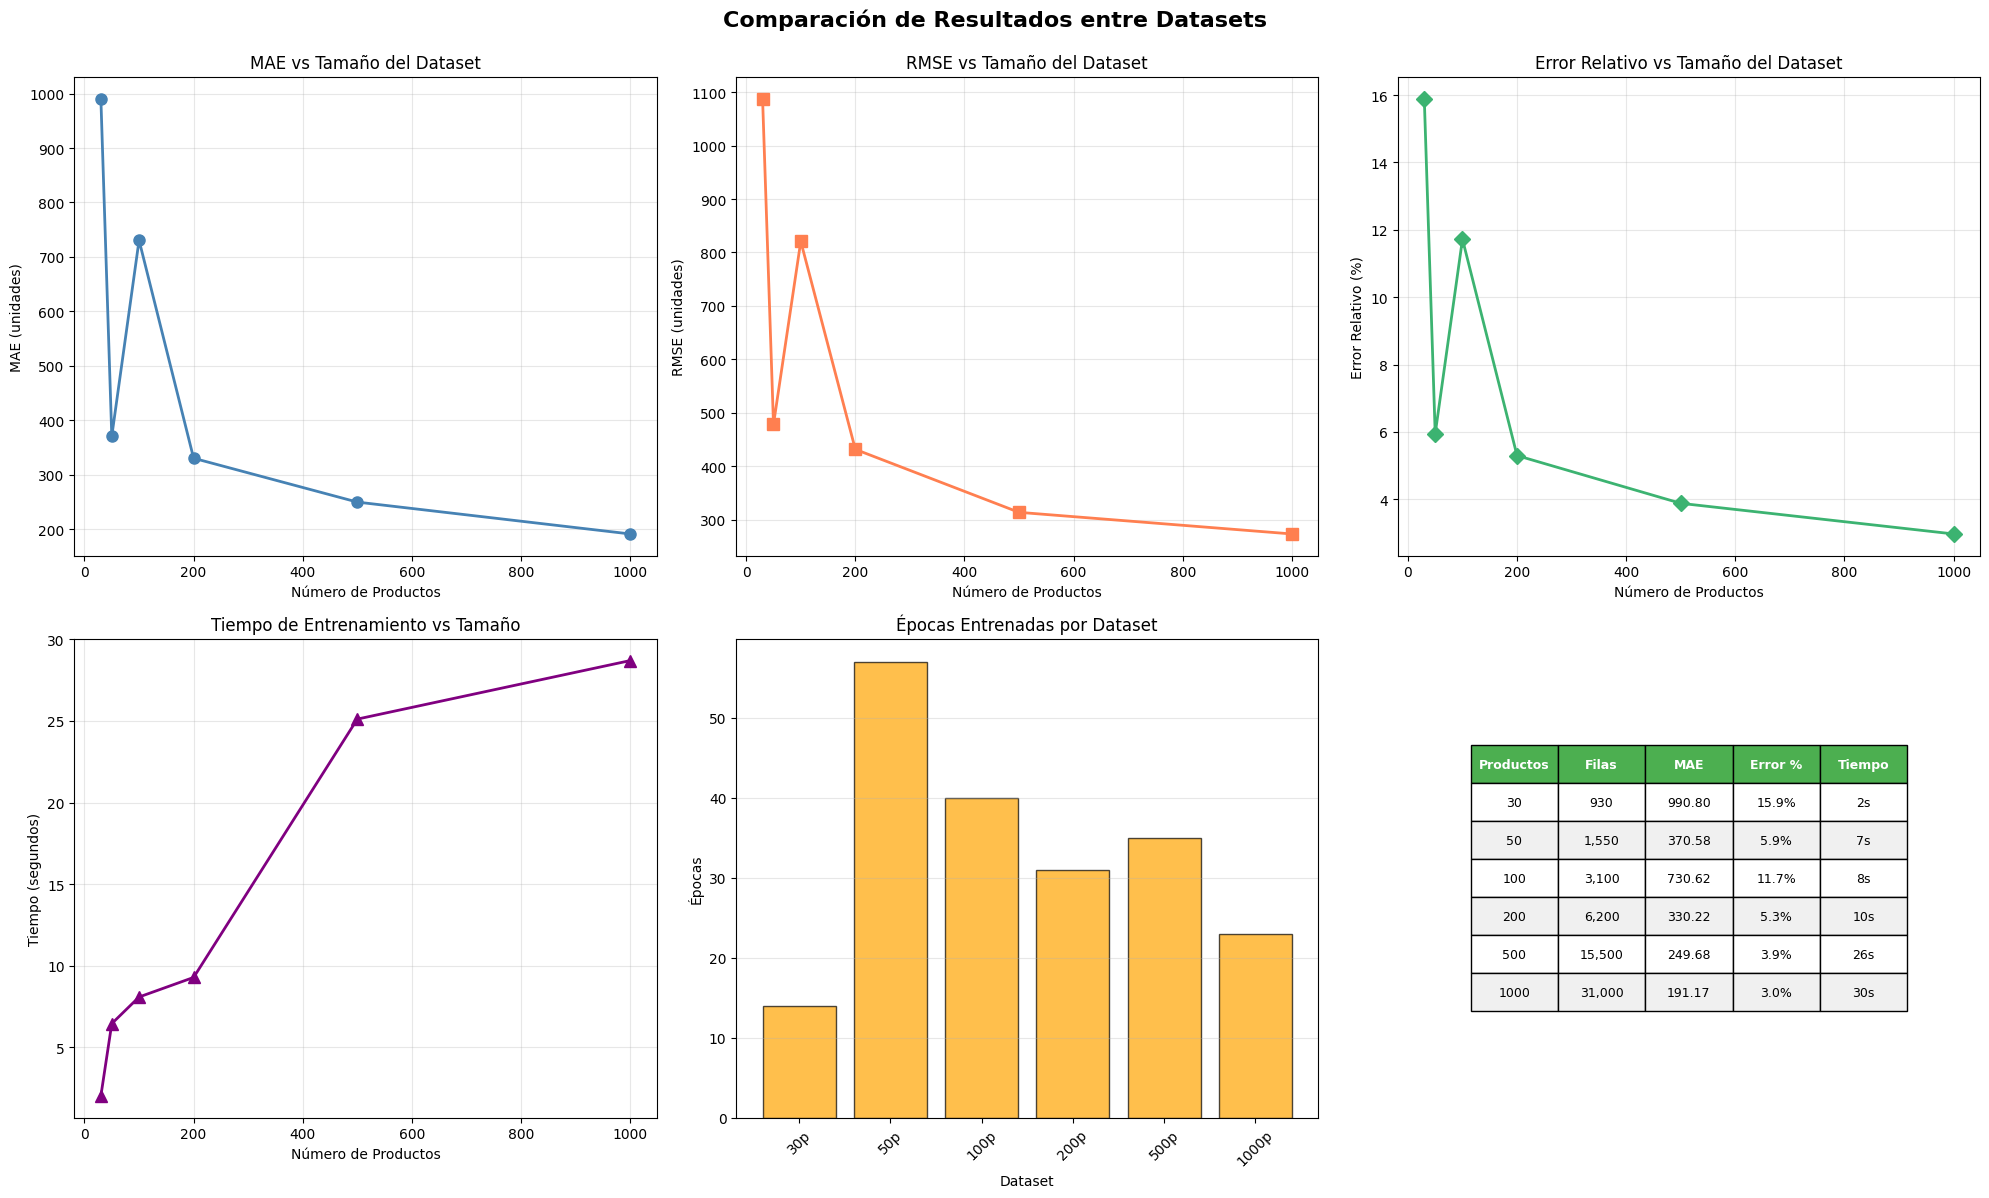


Generando visualizaciones individuales (6 datasets)...
   • subset_1000_productos


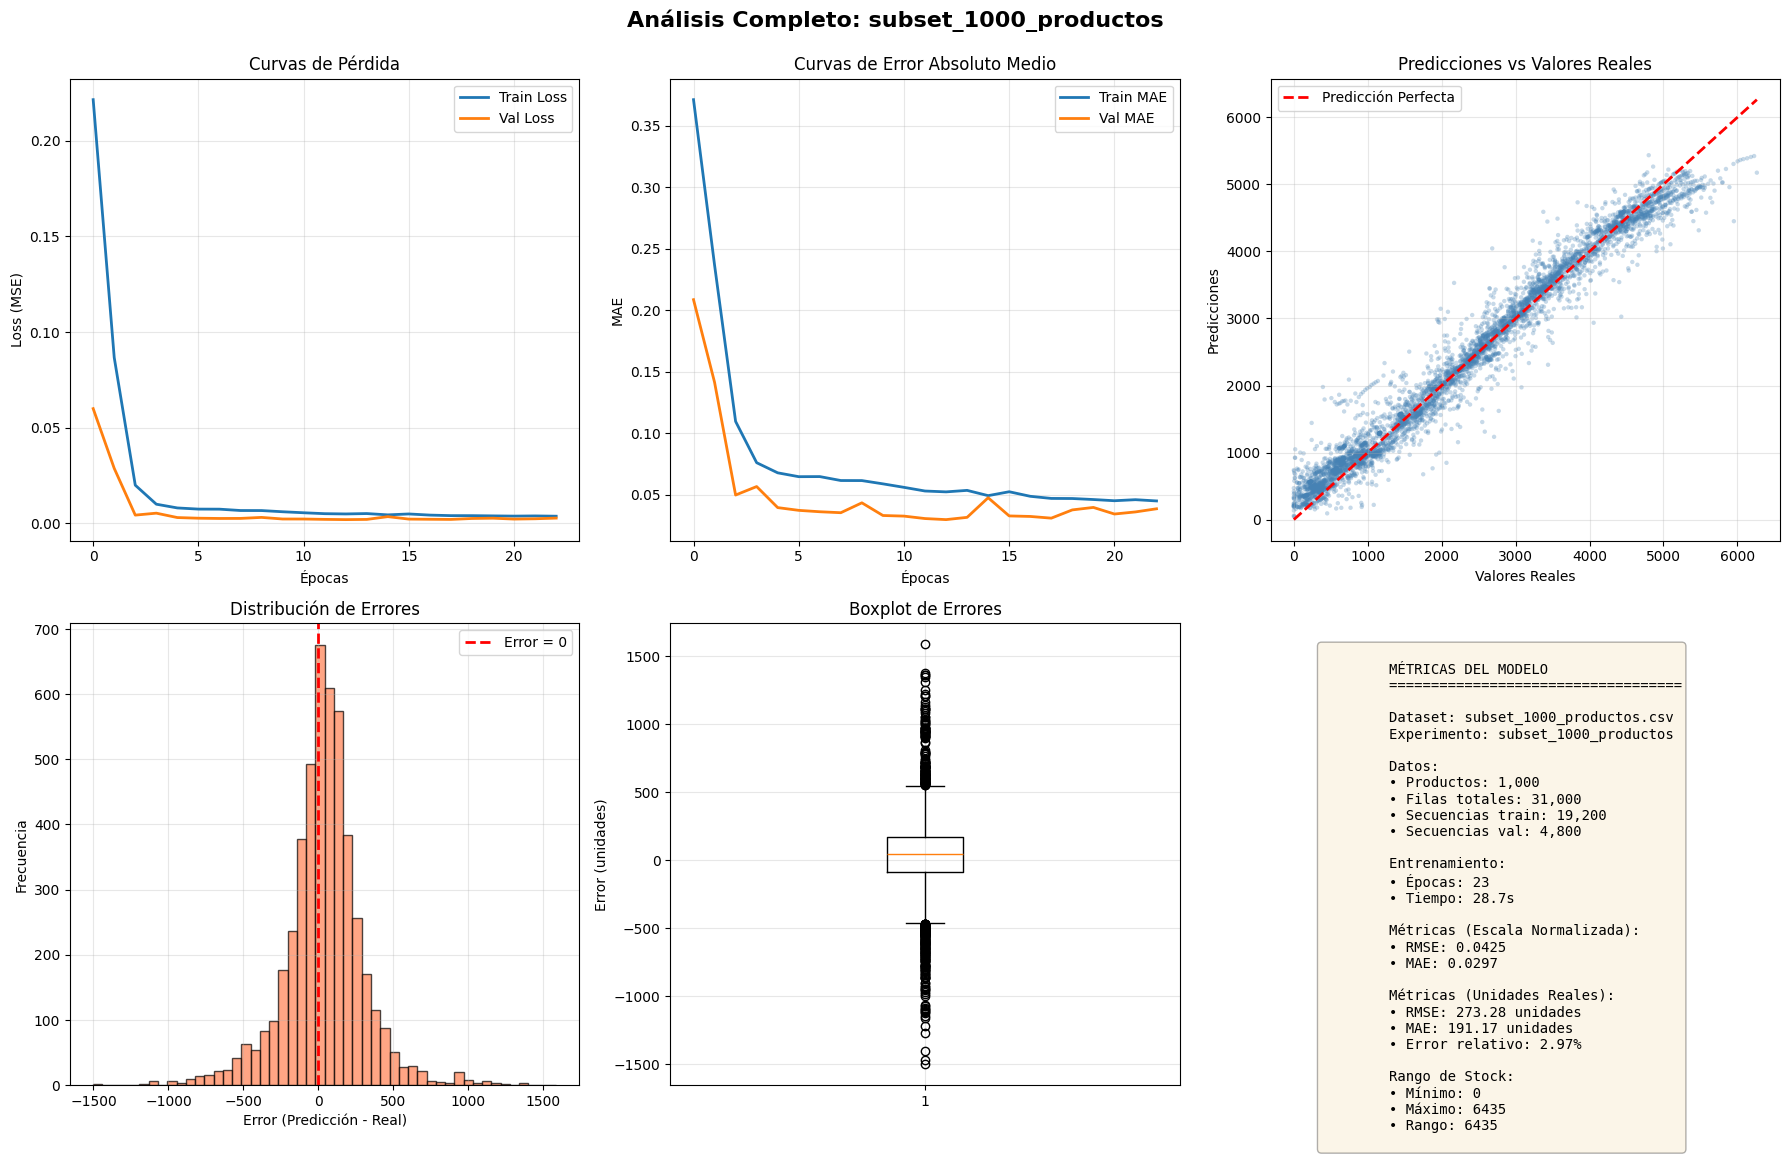

   • subset_100_productos


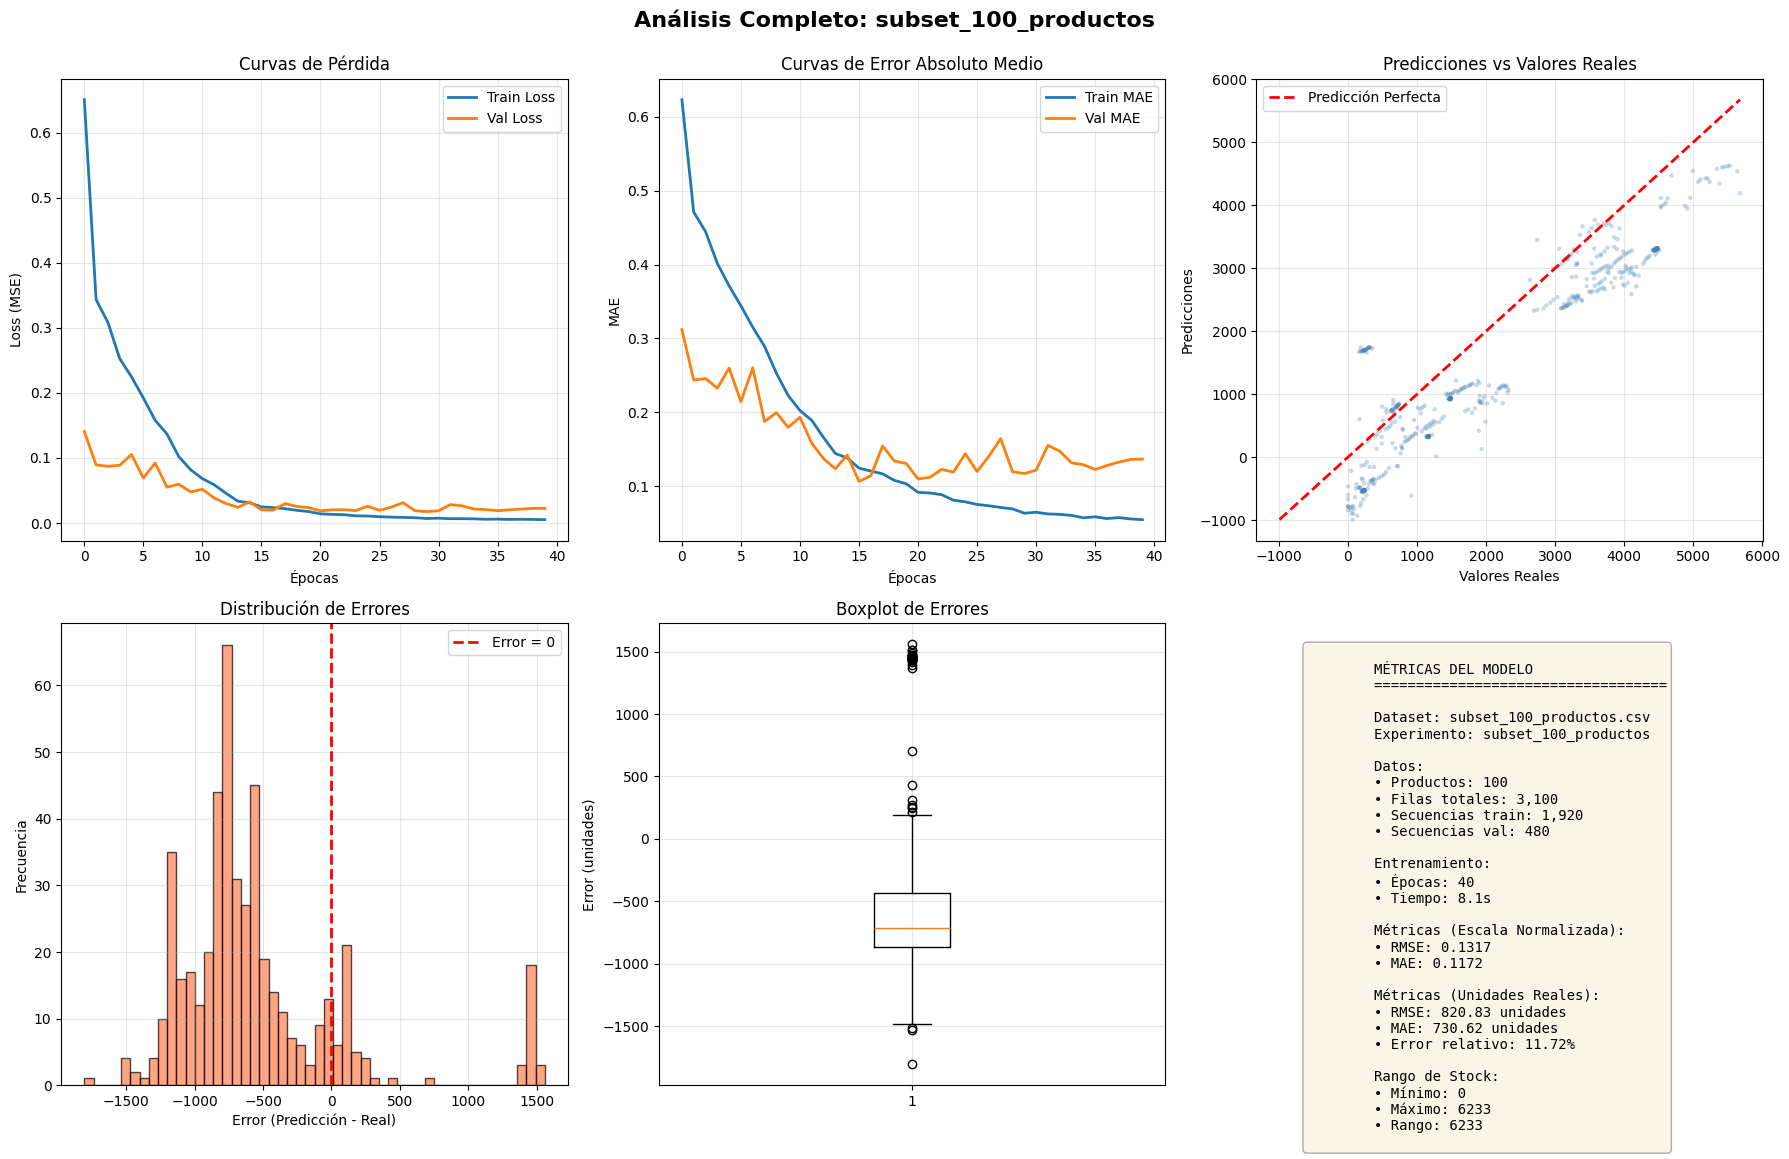

   • subset_200_productos


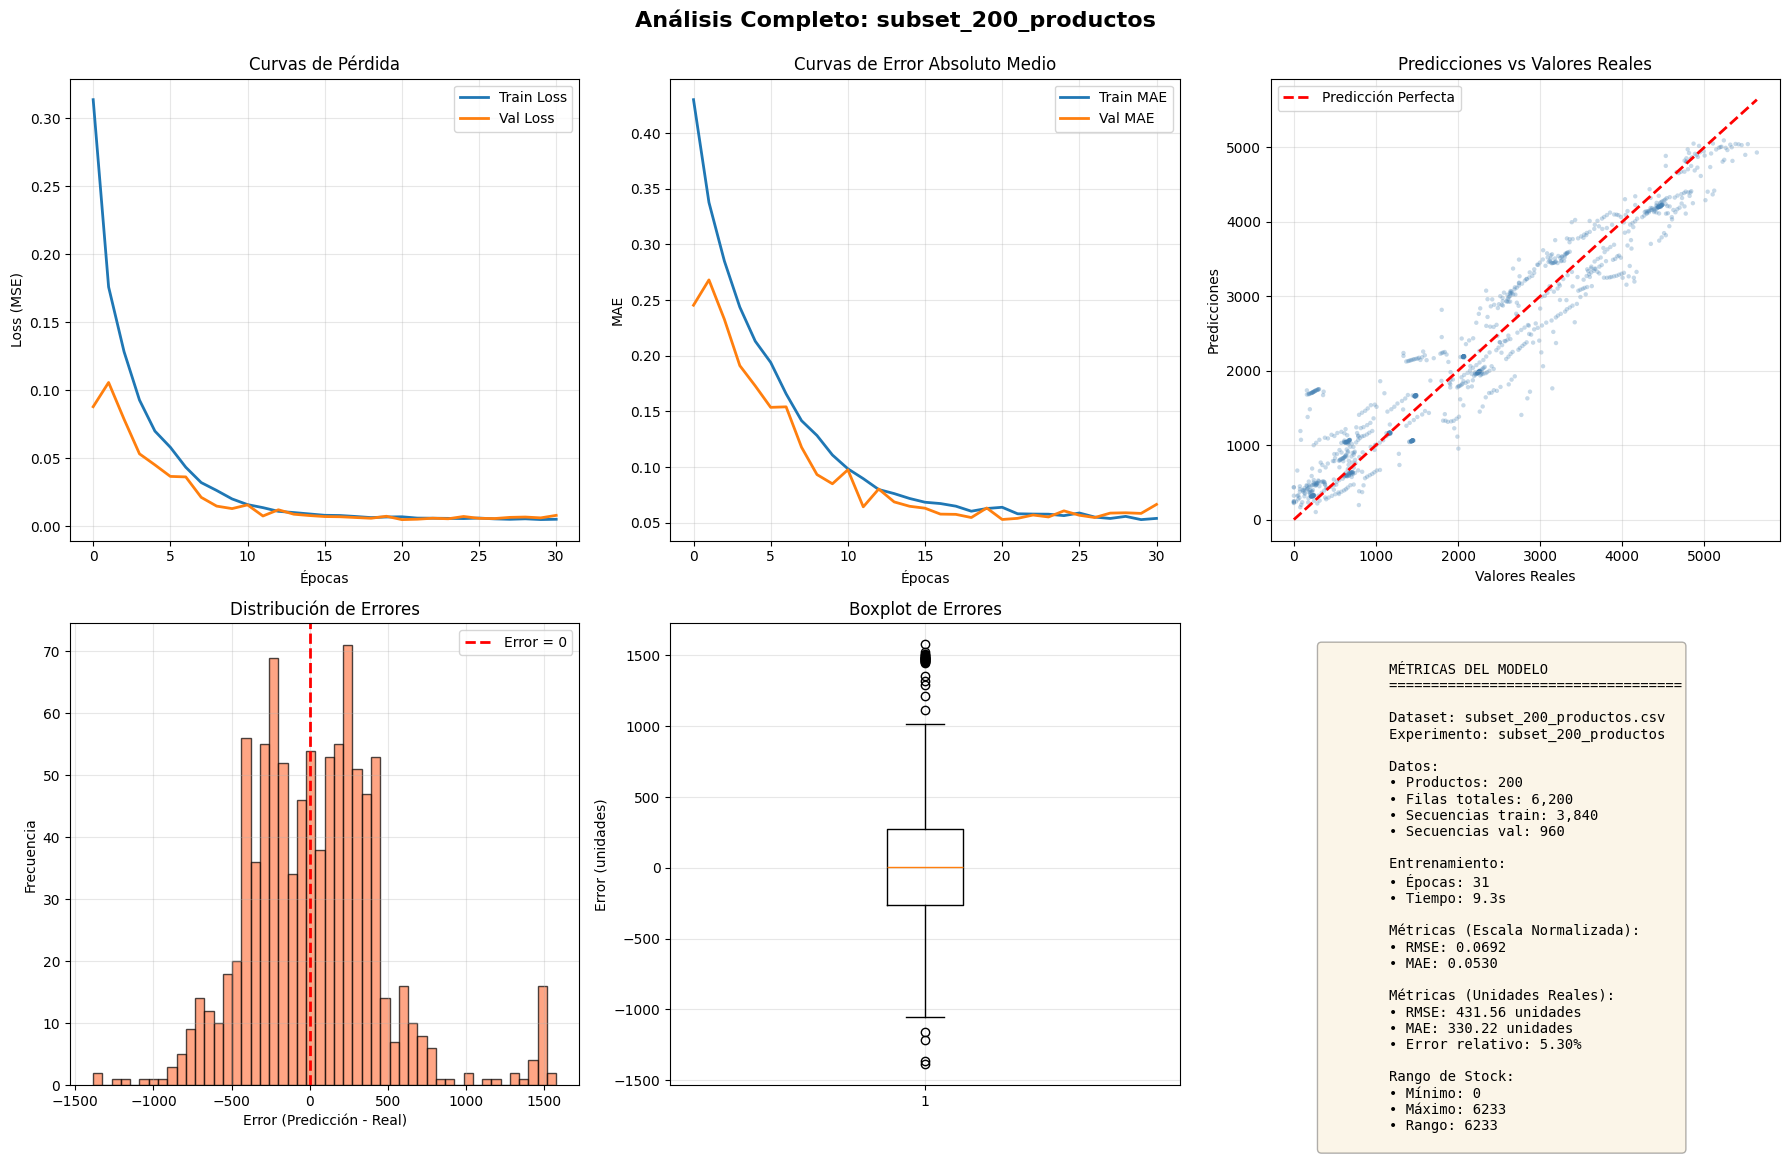

   • subset_30_productos


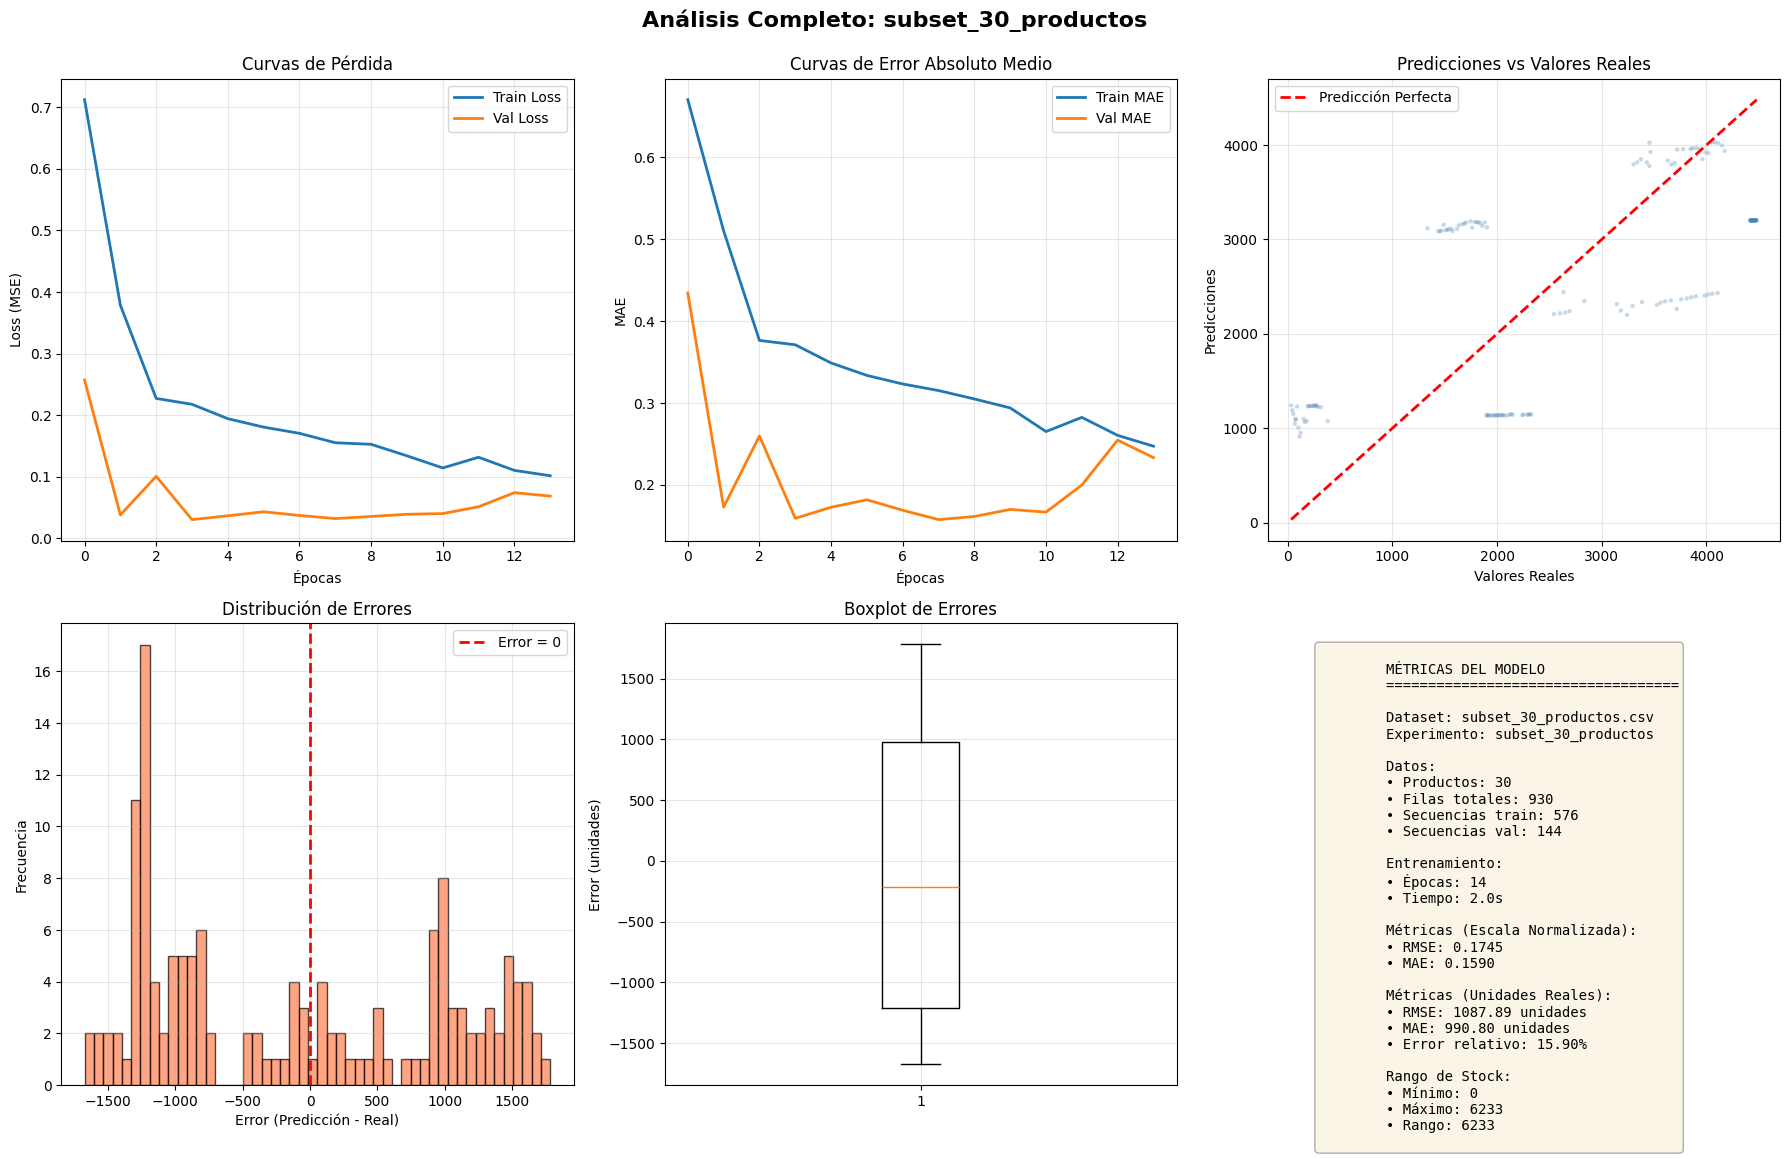

   • subset_500_productos


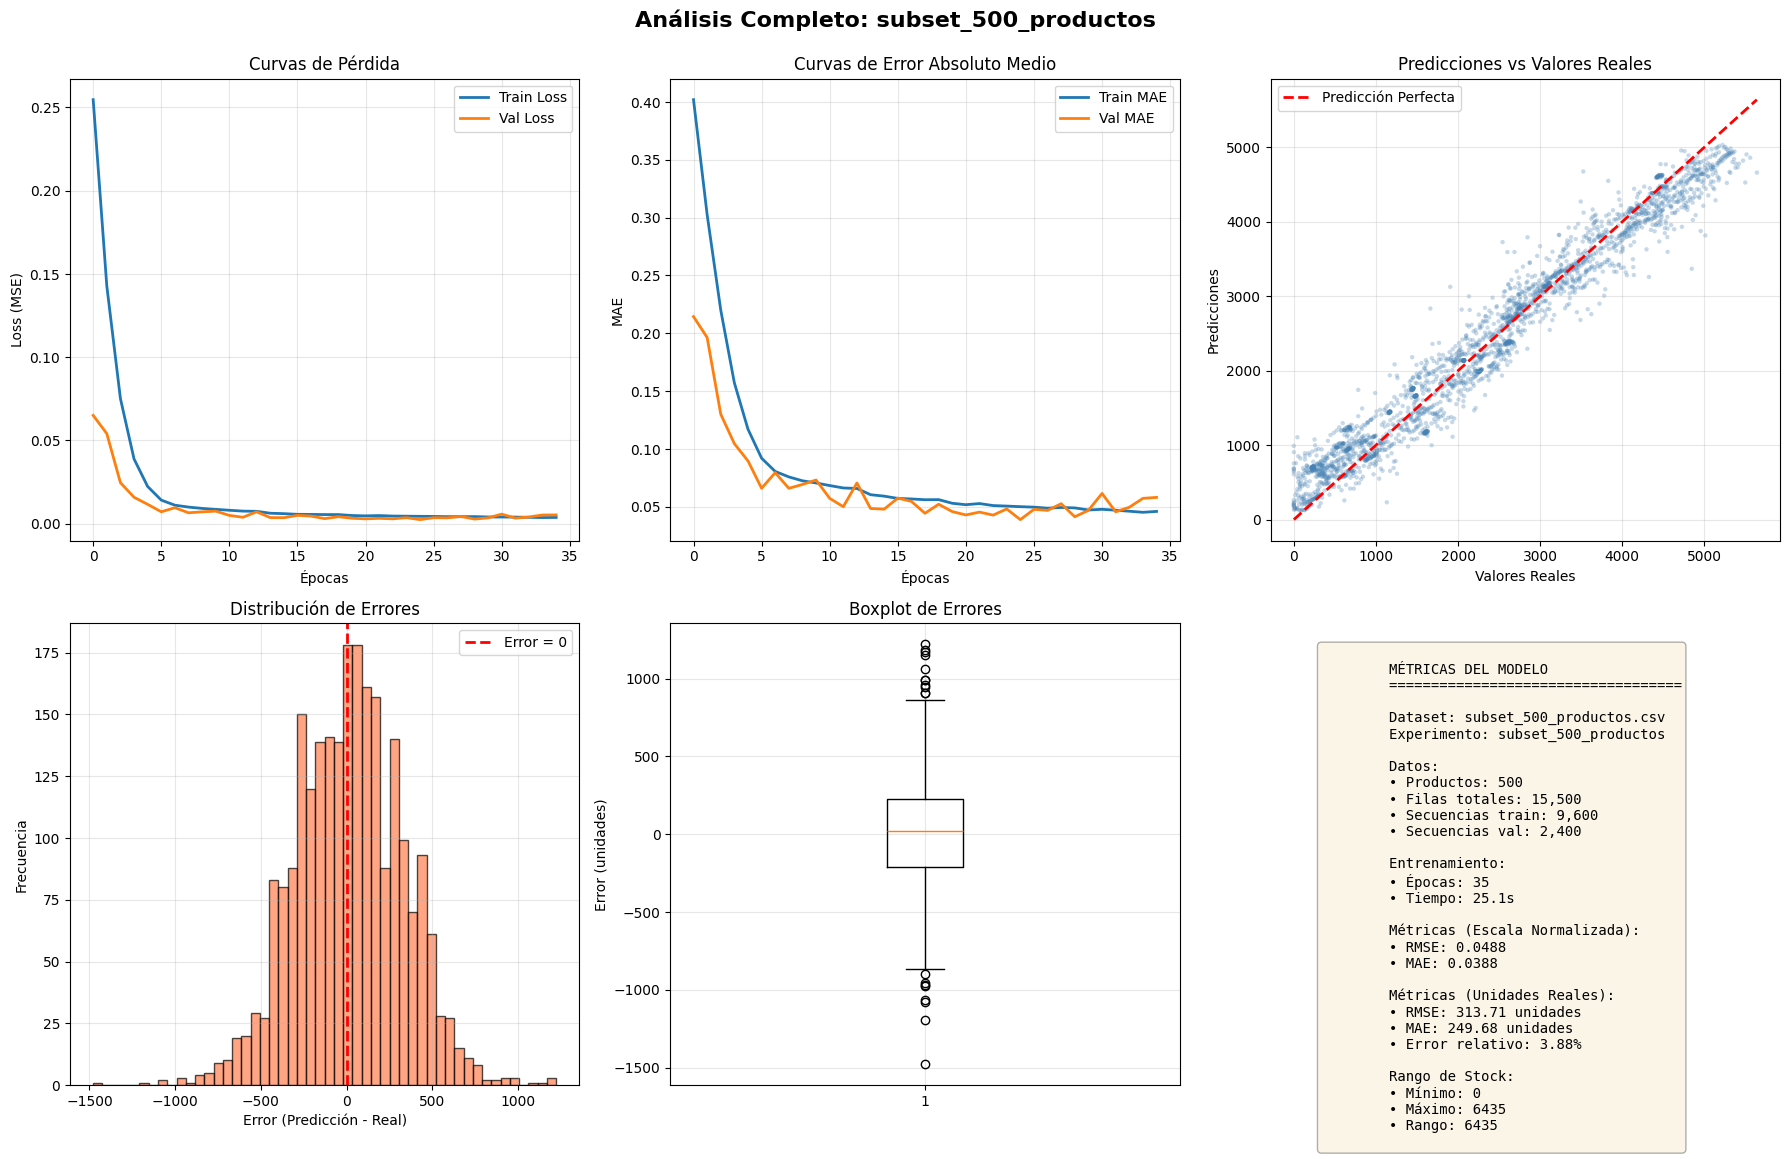

   • subset_50_productos


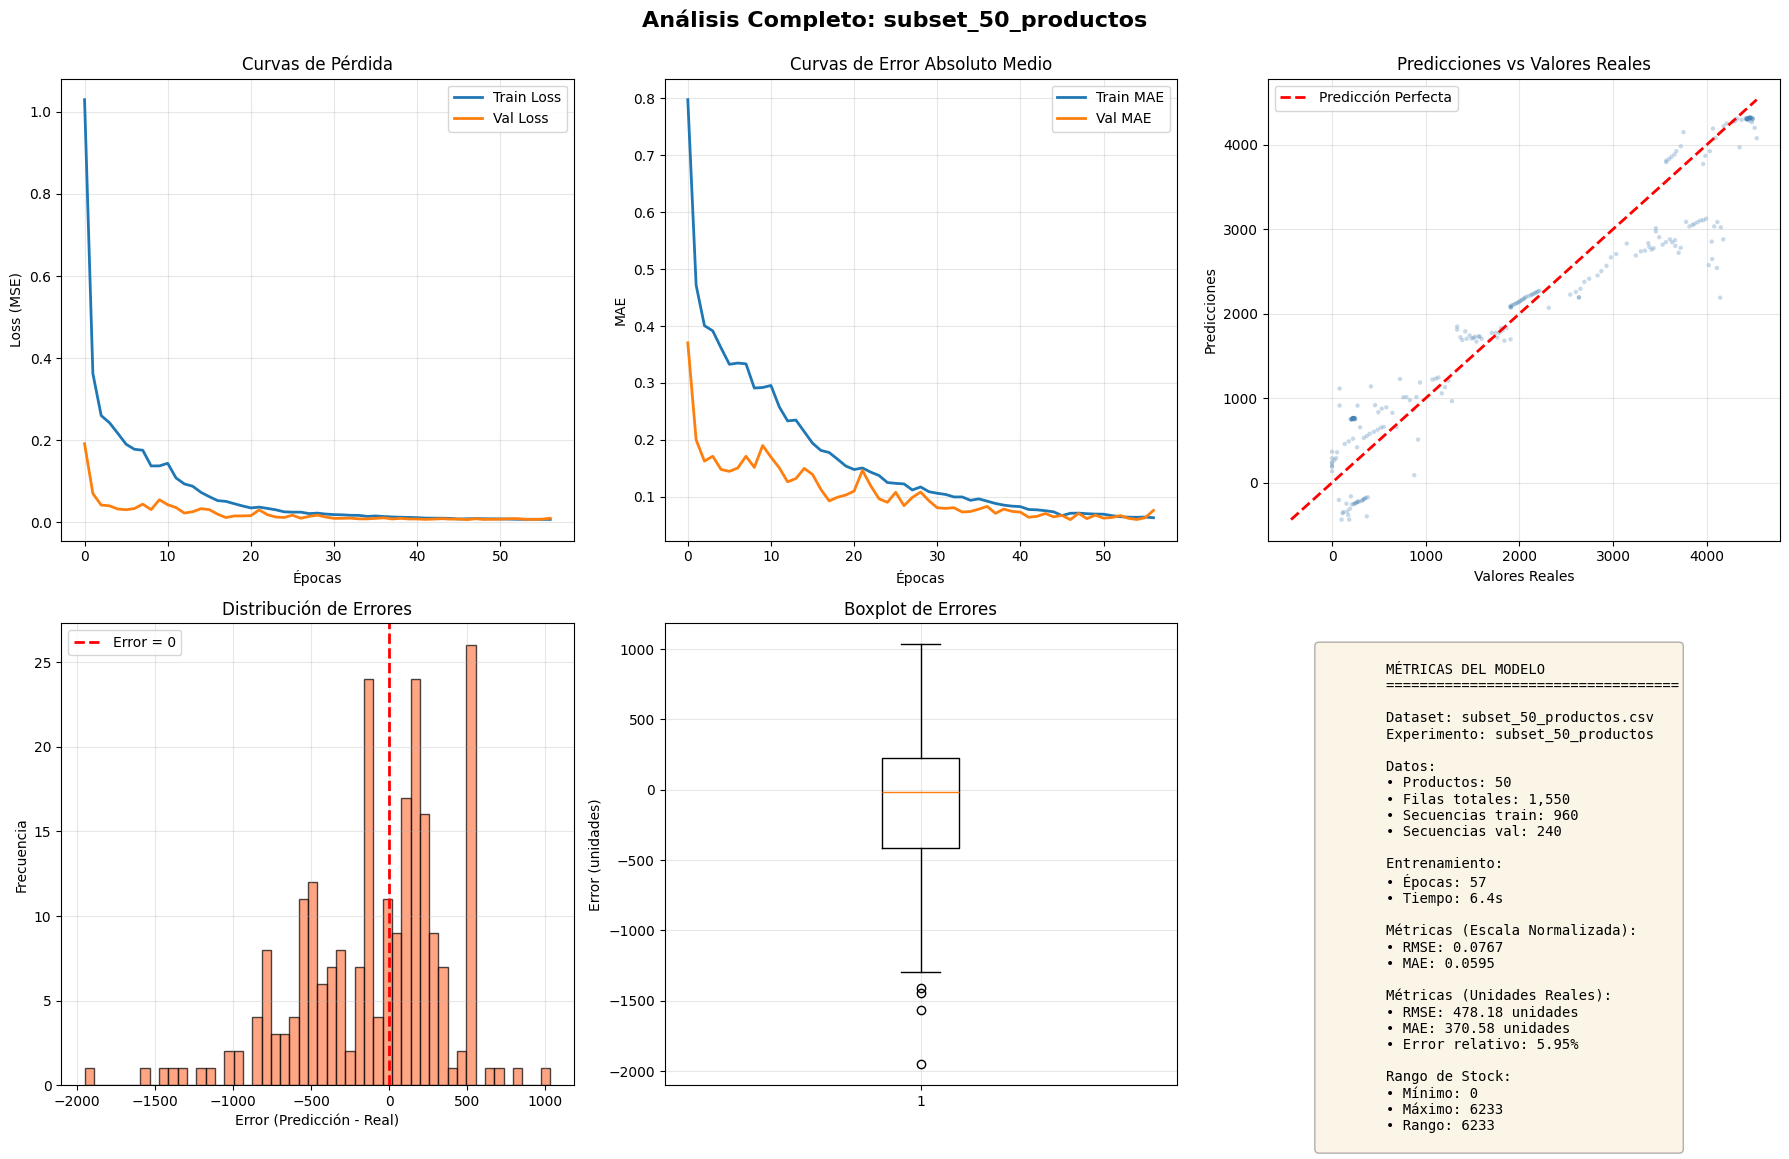


TABLA RESUMEN:
               nombre  productos_unicos  total_filas  secuencias_train   mae_real   rmse_real  error_relativo_pct  tiempo_total
  subset_30_productos                30          930               576 990.798005 1087.890511           15.896005      2.252943
  subset_50_productos                50         1550               960 370.584919  478.176131            5.945531      6.756726
 subset_100_productos               100         3100              1920 730.618667  820.825689           11.721782      8.348653
 subset_200_productos               200         6200              3840 330.221022  431.558943            5.297947      9.692632
 subset_500_productos               500        15500              9600 249.683949  313.714413            3.880092     25.956741
subset_1000_productos              1000        31000             19200 191.173796  273.277390            2.970844     30.328795

✓ Resultados guardados en: resultados_comparacion.csv

MEJOR DATASET según mae_real:
  

In [37]:
# Generar reporte completo con todas las visualizaciones
df_resultados = evaluador_multi.generar_reporte_completo(guardar=True)

# Mostrar el mejor dataset
mejor = evaluador_multi.mejor_dataset(metrica='mae_real')

print("\n" + "="*70)
print("CONCLUSIONES")
print("="*70)
print(f"\nMejor performance: {mejor['nombre']}")
print(f"  • MAE: {mejor['mae_real']:.2f} unidades")
print(f"  • RMSE: {mejor['rmse_real']:.2f} unidades")
print(f"  • Error relativo: {mejor['error_relativo_pct']:.2f}%")
print(f"  • Productos: {mejor['productos_unicos']}")
print(f"  • Tiempo de entrenamiento: {mejor['tiempo_entrenamiento']:.1f}s")
print("\n" + "="*70)

## 5. Análisis Individual de un Dataset Específico

Si quieres analizar en detalle un dataset específico, usa esta sección.


ANÁLISIS DETALLADO: subset_1000_productos


RESUMEN EJECUTIVO: subset_1000_productos

DATOS:
   • Dataset: subset_1000_productos.csv
   • Productos únicos: 1,000
   • Total de filas: 31,000
   • Secuencias train: 19,200
   • Secuencias validación: 4,800

ENTRENAMIENTO:
   • Épocas ejecutadas: 23
   • Tiempo de entrenamiento: 28.7s

MÉTRICAS:
   • RMSE (real): 273.28 unidades
   • MAE (real): 191.17 unidades
   • Error relativo: 2.97%

⏱TIEMPOS:
   • Carga: 0.08s
   • Preprocesamiento: 0.05s
   • Secuencias: 1.11s
   • Entrenamiento: 28.70s
   • Evaluacion: 0.36s
   • Total: 30.33s




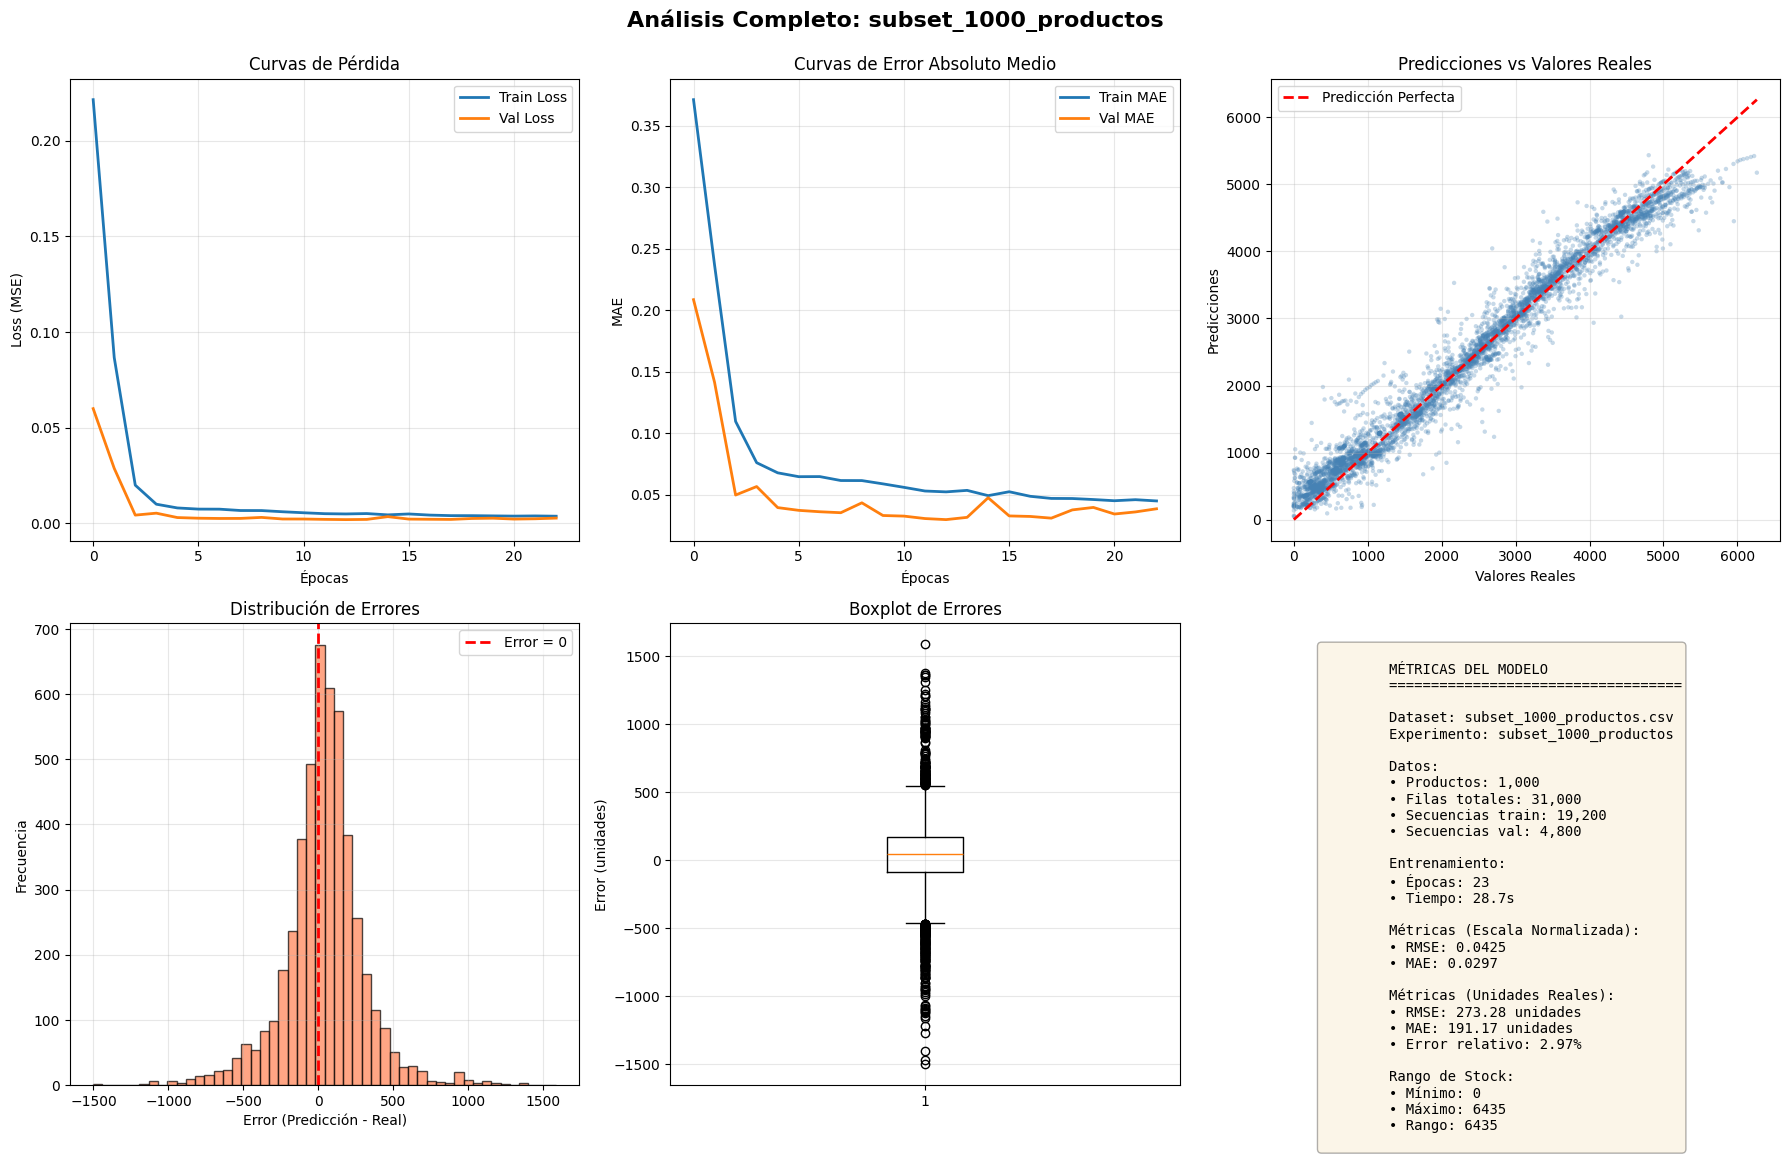


ANÁLISIS DE PREDICCIONES:
   • Predicción mínima: 46.81
   • Predicción máxima: 5435.52
   • Predicción promedio: 2427.46

   • Real mínimo: 0.00
   • Real máximo: 6264.00
   • Real promedio: 2391.32

ESTADÍSTICAS DE ERRORES:
   • Error medio: 36.14
   • Desviación estándar: 270.88
   • Error mínimo: -1501.98
   • Error máximo: 1585.44
   • Percentil 25: -86.82
   • Percentil 75: 166.38


In [38]:
# Seleccionar un dataset específico para análisis detallado
DATASET_ESPECIFICO = 'subset_1000_productos'  # Cambia esto al dataset que quieras analizar

if DATASET_ESPECIFICO in evaluador_multi.evaluadores:
    eval_especifico = evaluador_multi.evaluadores[DATASET_ESPECIFICO]
    
    print(f"\n{'='*70}")
    print(f"ANÁLISIS DETALLADO: {DATASET_ESPECIFICO}")
    print(f"{'='*70}\n")
    
    # Resumen
    eval_especifico.resumen()
    
    # Visualizaciones
    eval_especifico.generar_visualizaciones(mostrar=True)
    
    # Análisis de predicciones
    print("\nANÁLISIS DE PREDICCIONES:")
    print(f"   • Predicción mínima: {eval_especifico.y_pred_real.min():.2f}")
    print(f"   • Predicción máxima: {eval_especifico.y_pred_real.max():.2f}")
    print(f"   • Predicción promedio: {eval_especifico.y_pred_real.mean():.2f}")
    print(f"\n   • Real mínimo: {eval_especifico.y_val_real.min():.2f}")
    print(f"   • Real máximo: {eval_especifico.y_val_real.max():.2f}")
    print(f"   • Real promedio: {eval_especifico.y_val_real.mean():.2f}")
    
    # Estadísticas de errores
    errores = eval_especifico.y_pred_real - eval_especifico.y_val_real
    print(f"\nESTADÍSTICAS DE ERRORES:")
    print(f"   • Error medio: {errores.mean():.2f}")
    print(f"   • Desviación estándar: {errores.std():.2f}")
    print(f"   • Error mínimo: {errores.min():.2f}")
    print(f"   • Error máximo: {errores.max():.2f}")
    print(f"   • Percentil 25: {np.percentile(errores, 25):.2f}")
    print(f"   • Percentil 75: {np.percentile(errores, 75):.2f}")
    
else:
    print(f"Dataset '{DATASET_ESPECIFICO}' no encontrado")
    print(f"Datasets disponibles: {list(evaluador_multi.evaluadores.keys())}")

## 6. Exportar Resultados y Predicciones

Guarda las predicciones y métricas de un dataset específico para análisis posterior.

In [39]:
# Seleccionar dataset para exportar
DATASET_EXPORTAR = 'subset_500_productos'  # Cambia esto

if DATASET_EXPORTAR in evaluador_multi.evaluadores:
    eval_exp = evaluador_multi.evaluadores[DATASET_EXPORTAR]
    
    # Crear directorio de resultados
    resultados_dir = Path('resultados_evaluacion')
    resultados_dir.mkdir(exist_ok=True)
    
    # 1. Exportar predicciones
    df_predicciones = pd.DataFrame({
        'valor_real': eval_exp.y_val_real,
        'prediccion': eval_exp.y_pred_real,
        'error': eval_exp.y_pred_real - eval_exp.y_val_real,
        'error_abs': np.abs(eval_exp.y_pred_real - eval_exp.y_val_real)
    })
    
    pred_path = resultados_dir / f'predicciones_{DATASET_EXPORTAR}.csv'
    df_predicciones.to_csv(pred_path, index=False)
    print(f"Predicciones exportadas a: {pred_path}")
    
    # 2. Exportar métricas
    metricas_dict = {
        'experimento': DATASET_EXPORTAR,
        'fecha': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        **eval_exp.resultados,
        **{f'tiempo_{k}': v for k, v in eval_exp.tiempos.items()}
    }
    
    metricas_path = resultados_dir / f'metricas_{DATASET_EXPORTAR}.json'
    with open(metricas_path, 'w') as f:
        json.dump(metricas_dict, f, indent=2, default=str)
    print(f"Métricas exportadas a: {metricas_path}")
    
    # 3. Guardar modelo
    modelo_path = resultados_dir / f'modelo_{DATASET_EXPORTAR}.keras'
    eval_exp.model.save(modelo_path)
    print(f"Modelo guardado en: {modelo_path}")
    
    # 4. Guardar historia de entrenamiento
    historia_path = resultados_dir / f'historia_{DATASET_EXPORTAR}.csv'
    df_historia = pd.DataFrame(eval_exp.history.history)
    df_historia.to_csv(historia_path, index=False)
    print(f"Historia de entrenamiento guardada en: {historia_path}")
    
    print(f"\nTodos los resultados exportados a: {resultados_dir}/")
    
    # Mostrar muestra de predicciones
    print(f"\nMuestra de predicciones:")
    print(df_predicciones.head(10).to_string(index=False))
    print(f"\n   Total de predicciones: {len(df_predicciones):,}")
    
else:
    print(f"Dataset '{DATASET_EXPORTAR}' no encontrado")

Predicciones exportadas a: resultados_evaluacion/predicciones_subset_500_productos.csv
Métricas exportadas a: resultados_evaluacion/metricas_subset_500_productos.json
Modelo guardado en: resultados_evaluacion/modelo_subset_500_productos.keras
Historia de entrenamiento guardada en: resultados_evaluacion/historia_subset_500_productos.csv

Todos los resultados exportados a: resultados_evaluacion/

Muestra de predicciones:
 valor_real  prediccion       error  error_abs
4368.000053 3957.610594 -410.389459 410.389459
4405.000156 3961.236348 -443.763808 443.763808
4429.000015 3984.938568 -444.061447 444.061447
4455.000118 4004.807914 -450.192204 450.192204
4471.000152 4023.835738 -447.164414 447.164414
4119.000173 4040.254998  -78.745175  78.745175
4517.999940 3913.628241 -604.371699 604.371699
4210.999888 4009.216505 -201.783383 201.783383
3951.000009 3945.621404   -5.378604   5.378604
4078.999896 3805.333920 -273.665976 273.665976

   Total de predicciones: 2,400
